# Prepare data

Importing COVID-19 Data

In [1]:
import json

with open('Resources/dpc-covid19-ita-province.json') as f:
    d = json.load(f)

Importing NetworkX and Pandas

In [174]:
import networkx as nx
import pandas as pd
import numpy as np
import math as mt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pygraphviz as pgv
import graphviz as gvz
from IPython.display import Image
import llist as ll

Cleaning data

In [3]:
# Create a DataFrame with COVID data, we need just some columns
city_dataframe = pd.DataFrame(d)[['denominazione_provincia', 'lat', 'long']].drop_duplicates()

print("Dataframe contains " + str(city_dataframe.count()[0]) + " rows")

# Remove data having latitude = 0 or longitude = 0 or provincia = "In fase di definizione/aggiornamento"
city_dataframe.drop(city_dataframe[(city_dataframe['lat'] == 0) | \
                                   (city_dataframe['long'] == 0) | \
                                   (city_dataframe['denominazione_provincia'] == 'In fase di definizione/aggiornamento') \
                                  ].index, inplace = True)

city_dataframe.reset_index(drop = True, inplace = True)
                        
print("After removing unusable data, Dataframe contains " + str(city_dataframe.count()[0]) + " rows")

Dataframe contains 108 rows
After removing unusable data, Dataframe contains 107 rows


In [4]:
city_dataframe

denominazione_provincia        lat       long
0                    Chieti  42.351032  14.167546
1                  L'Aquila  42.351222  13.398438
2                   Pescara  42.464584  14.213648
3                    Teramo  42.658918  13.704400
4                    Matera  40.667512  16.597924
..                      ...        ...        ...
102                  Rovigo  45.071073  11.790070
103                 Treviso  45.667546  12.245074
104                 Venezia  45.434905  12.338452
105                  Verona  45.438390  10.993527
106                 Vicenza  45.547497  11.545971

[107 rows x 3 columns]

# Algorithms
We are not explicitly adding nodes to graph $\Rightarrow$ nodes without any edge will not be put in the graph
## 1. Iteration over all couples $\rightarrow$ Cost: $\mathcal{\Theta}\ (\ n^2\ )$

In [5]:
def allCoupleEdges(graph, dataframe, radius):
    # O (n)
    for i in dataframe.index:

        # O (n)
        for j in dataframe.index:
            if i != j and \
               dataframe.iloc[i, 1] - radius <= dataframe.iloc[j, 1] and \
               dataframe.iloc[i, 1] + radius >= dataframe.iloc[j, 1] and \
               dataframe.iloc[i, 2] - radius <= dataframe.iloc[j, 2] and \
               dataframe.iloc[i, 2] + radius >= dataframe.iloc[j, 2]:
                graph.add_edge(dataframe.iloc[i, 0], dataframe.iloc[j, 0])                        

## 2. Binary search on ordered dataframe $\rightarrow$ Cost: $\mathcal{\Theta}\ (\ n \cdot \log{} n\ )$

### Utility function
Given a dataframe with:
 - Column 0 $\rightarrow$ ID
 - Column 1 $\rightarrow$ Position  
 
Returns a set of all ID couples within *radius* distance

In [6]:
def binarySearchSingle(dataframe, radius):
    # Edges between near cities basing on x position
    # Use of dictionary, in this way search of an element costs O(1)
    edges = {}
    
    # Sort dataframe basing on position O (n log n) using quicksort
    # Use of tmpDataframe to leave dataframe as received
    tmpDataframe = dataframe.sort_values(by = dataframe.columns[1])
    tmpDataframe.reset_index(drop = True, inplace = True)
    
    # O(n)
    for i in tmpDataframe.index:        
        # Set pointers to be used in iterative binary search
        first = 0
        # We just check the left half because we do not need double couples (a, b) and (b, a).
        last = i - 1
        found = False

        # O (log n)
        while first <= last and not found:
            midpoint = (first + last) // 2
        
            # Check if element at midpoint position is near enough            
            if tmpDataframe.iloc[i, 1] - radius <= tmpDataframe.iloc[midpoint, 1]:
                
                # If element at midpoint position is the leftmost element within radius distance
                # i.e. element at (midpoint - 1) position is too far
                if midpoint == 0 or tmpDataframe.iloc[i, 1] - radius > tmpDataframe.iloc[midpoint - 1, 1]:
                
                    # We add to edges all couples composed by (element at i position, element at j position)
                    # for all j from midpoint to i (excluded)
                    edges.update([((tmpDataframe.iloc[i, 0], tmpDataframe.iloc[j, 0]), None) 
                                  for j in range(midpoint, i)])
                    found = True
                
                # Otherwise (element at (midpoint - 1) position is near enough)
                # We search in left half
                else:
                    last = midpoint - 1             
                    
            # Otherwise we must search in right half
            else:
                first = midpoint + 1
                
    return edges

In [7]:
def binarySearchEdges(graph, dataframe, radius):
    xEdges = binarySearchSingle(dataframe, radius)
    yEdges = binarySearchSingle(dataframe.iloc[:, 0::2],  radius)
            
    # O(n)
    for k in xEdges.keys():
        # Searching both for (a,b) and (b,a)
        # O(1)
        if k in yEdges or k[::-1] in yEdges:
            graph.add_edge(*k)

# 1. Create Graph of cities
Build the graph of provinces P using NetworkX. Each node corresponds to a city and two cities a and b are connected by an edge if the following holds: if x,y is the position of a, then b is in position z,w with z in [x-d,x+d] and w in [y-d, y+d], with d=0.8. The graph is symmetric. Use the latitude and longitude information available in the files to get the position of the cities. This task can be done in several ways. Use the one you think is more efficient.

## Set up variables

In [8]:
P_all_couples = nx.Graph()
P = nx.Graph()
radius = 0.8

## Create Graph using algorithm # 1

In [9]:
%%timeit
P_all_couples.clear()
allCoupleEdges(P_all_couples, city_dataframe, radius)

413 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Create Graph using algorithm # 2

In [10]:
%%timeit
P.clear()
binarySearchEdges(P, city_dataframe, radius)

56.2 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Checking results of algorithms

In [11]:
if P.nodes != P_all_couples.nodes:
    raise Exception("P.nodes != P_all_couples.nodes")
    
if P.edges != P_all_couples.edges:
    raise Exception("P.edges != P_all_couples.edges")

# 2. Create graph of point
Generate 2000 pairs of double (x,y) with x in [30,50) and y in [10,20). Repeat the algorithm at step 1, building a graph R using NetworkX where each pair is a node and two nodes are connected with the same rule reported above, still with d=0.08. If the algorithm at step 1 takes too long, repeat step 1. Note that here d=0.08 (and not 0.8 as in the previous item), as in this way the resulting graph is sparser.

## Set up variables

In [12]:
radius = 0.08
R = nx.Graph()
xMin = 30
xMax = 50
yMin = 10
yMax = 20
couples_count = 2000
points_dataframe = pd.DataFrame()

# Generate column x with couples_count rows of elements in [xMin, xMax)
points_dataframe['x'] = np.random.random_sample(couples_count) * (xMax - xMin) + xMin

# Generate column y with couples_count rows of elements in [yMin, yMax)
points_dataframe['y'] = np.random.random_sample(couples_count) * (yMax - yMin) + yMin

# Generate column label with couples_count rows of (x value, y value)
points_dataframe['label'] = "(" + points_dataframe['x'].astype(str) + ", " + points_dataframe['x'].astype(str) + ")"
points_dataframe = points_dataframe[['label', 'x', 'y']]

# Replace duplicates to have clean data
# We just change y value and check that new couple is unique
for dup_ind in points_dataframe[points_dataframe.duplicated()].index:
    while (points_dataframe['label'].value_counts()[points_dataframe.loc[dup_ind, 'label']]) > 1:
        points_dataframe.loc[dup_ind, 'y'] = np.random.random_sample() * (yMax - yMin) + yMin
        points_dataframe.loc[dup_ind, 'label'] = "(" + str(points_dataframe.loc[dup_ind, 'x']) + \
          ", " + str(points_dataframe.loc[dup_ind, 'y']) + ")"

In [13]:
points_dataframe

label          x          y
0       (39.59628572921768, 39.59628572921768)  39.596286  18.383568
1       (48.01985865719932, 48.01985865719932)  48.019859  18.620447
2     (31.126797055655338, 31.126797055655338)  31.126797  19.430734
3       (35.41273926174117, 35.41273926174117)  35.412739  16.253771
4       (37.45355347053327, 37.45355347053327)  37.453553  15.278919
...                                        ...        ...        ...
1995  (30.801809539782987, 30.801809539782987)  30.801810  10.309415
1996    (35.78400094372793, 35.78400094372793)  35.784001  16.573052
1997    (41.25910405346072, 41.25910405346072)  41.259104  11.360705
1998    (39.78791497256571, 39.78791497256571)  39.787915  13.120621
1999    (38.22685866352509, 38.22685866352509)  38.226859  12.413488

[2000 rows x 3 columns]

## Create Graph using algorithm # 1

In [14]:
#%%timeit
#P_all_couples.clear()
#allCoupleEdges(P_all_couples, points_dataframe, radius)
print('Cell commented because of high time consuming, executed just once with result:')
print('1min 25s ± 234 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)')

Cell commented because of high time consuming, executed just once with result:
1min 25s ± 234 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Create Graph using algorithm # 2

In [15]:
%%timeit
R.clear()
binarySearchEdges(R, points_dataframe, radius)

1.41 s ± 59.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 3. Weight graphs
Both P and R can be seen as weighted graphs putting on each edge the distance between the two cities. Modify P and R to weight their edges.

### Utility function
Given a graph and a dataframe containing all nodes of the graph with:
 - Column 0 $\rightarrow$ ID
 - Column 1 $\rightarrow$ X Position  
 - Column 2 $\rightarrow$ Y Position  
 
adds weight (distance) to each edge of the graph 

In [16]:
def weightGraph(graph, dataframe):
    for edge in graph.edges:
        graph.edges[edge]['weight'] = mt.sqrt(((dataframe.loc[dataframe.iloc[:, 0] == edge[0]].iloc[0, 1]) - \
                                         (dataframe.loc[dataframe.iloc[:, 0] == edge[1]].iloc[0, 1])) ** 2 +\
                                        ((dataframe.loc[dataframe.iloc[:, 0] == edge[0]].iloc[0, 2]) - \
                                         (dataframe.loc[dataframe.iloc[:, 0] == edge[1]].iloc[0, 2])) ** 2)

In [17]:
weightGraph(P, city_dataframe)
weightGraph(R, points_dataframe)

# 4. Eulerian Path

From Wikipedia (https://en.wikipedia.org/wiki/Eulerian_path):
In graph theory, an Eulerian trail (or Eulerian path) is a trail in a finite graph that visits every edge exactly once (allowing for revisiting vertices). Similarly, an Eulerian circuit or Eulerian cycle is an Eulerian trail that starts and ends on the same vertex.

## Utility function
Defining a generic function to draw graphs having an "order" attribute on edges.  
Edges will have different color basing on visit order and a label with visit order.

In [351]:
def draw_graph_viz(graph, attribute = None):
    cmap = plt.cm.get_cmap('Blues')
    norm = mpl.colors.Normalize(vmin = -2, vmax = len(graph.edges))
    
    # We want graph to be directed only if attribute != None
    # Otherwise it means we are drawing the original graph (unidrect)
    gr = pgv.AGraph(directed = (attribute != None))
    
    for start, end, attr in graph.edges(data = True):
        if attribute != None:
            gr.add_edge(start, end, color = str(mpl.colors.to_hex(cmap(norm(attr[attribute])))), \
                        label = " " + str(attr[attribute]))
        else:
            gr.add_edge(start, end)
            
    for node in graph.nodes():
        gr.add_node(node)
    
    gr.layout(prog = 'dot')
    gr.draw("file.png")
    display(Image("file.png"))    

In [352]:
def draw_graph(graph, attribute = None, figsize = None):
    plt.figure(figsize = figsize)
    cmap = plt.cm.Blues
    font_size = 25
    pos = nx.circular_layout(graph)
    node_color = '#A0CBE2'    
    node_size = 1500
    
    if attribute != None:
        # Retrieving labels to be put on edges
        edge_labels = dict([((start, end, ), attr[attribute]) \
                            for start, end, attr in graph.edges(data = True)])
        # Setting different colors on edges basing on attribute value
        colors = [attr[attribute] for start, end, attr in graph.edges(data = True)]
        
        nx.draw_networkx_edge_labels(graph, pos = pos, edge_labels = edge_labels, font_size = font_size)
        
        sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = min(colors), vmax=max(colors)))
        plt.colorbar(sm, ticks = colors)
        
    else:
        edge_labels = None
        colors = node_color
    
    nx.draw(graph, with_labels = True, pos = pos, \
            node_color = node_color, font_size = font_size, node_size = node_size, font_color = 'w', \
            edge_color = colors, width = 4, edge_cmap = cmap)
    plt.show()

## Exception definition
These exceptions will be used to manage eventual limitation of following algorithms

In [146]:
class NotConnectedGraph(Exception):
    def __init__(self, message):
        self.message = message
        
class TooManyOddNodes(Exception):
    def __init__(self, message):
        self.message = message        

## Fleury's algorithm
Fleury's algorithm is an elegant but inefficient algorithm.
 1. Check that graph has all edges in the same component
 2. Check that graph has at most 2 vertices of odd degree
 3. Choose a vertex of odd degree, if the graph has none choose an arbitrary vertex.  
    3.1 Choose next edge in the path to be one whose deletion would not disconnect the graph.  If there is no such edge pick the remaining edge left at the current vertex.  
    3.2 Use this edge to reach the other node and delete the edge.  
    3.3 If current vertex has no more edges it means that the Graph has no more edge. Otherwise return to 3.1
    
While the graph traversal in Fleury's algorithm is linear in the number of edges, i.e. $\mathcal{O}\ (\ |E|\ )$, we also need to factor in the complexity of detecting bridges.  
If we are to re-run Tarjan's linear time bridge-finding algorithm after the removal of every edge, Fleury's algorithm will have a time complexity of $\mathcal{O}\ (\ |E|^2\ )$.  
A dynamic bridge-finding algorithm of Thorup allows this to be improved to $\mathcal{O}\ (\ |E|\ \cdot\ (\ log\ ⁡|E|\ )^3\ log\ log\ |E|\ )$, but this is still significantly slower than alternative algorithms. 

In [173]:
def fleury(graph, viz = True):
    # graph that will represent with direct edges
    # the eulerian trail
    trail = nx.DiGraph()    
    
    # Check if graph is connected
    if not nx.is_connected(graph):
        raise NotConnectedGraph("Graph is not connected")

    # Use of tmpGraph to leave graph as received
    tmpGraph = graph.copy()
    
    # Check which nodes have odd degree and raise exception if more than 2 have been found
    odd_degree_nodes = []
    for node in tmpGraph.nodes:
        if tmpGraph.degree(node) % 2 != 0:
            odd_degree_nodes.append(node)
            if len(odd_degree_nodes) > 2:
                raise TooManyOddNodes("Graph has at least 3 nodes with odd degree: " + str(odd_degree_nodes))            
    
    print("Original graph")
    if viz:
        draw_graph_viz(graph)
    else:
        draw_graph(graph, figsize = (6, 6))
        
    # Start with a node with odd degree (if any)
    if len(odd_degree_nodes) > 0:
        node = odd_degree_nodes[0]
    else:
        node = [*tmpGraph.nodes][0]
    
    end = False
    trail.add_node(node)
    order = 1
    while not end:
        # Search non-bridge edges
        not_bridge_edges = {*tmpGraph.edges(node)} - {*nx.bridges(tmpGraph, node)}
        if len(not_bridge_edges) > 0:
            next_node = not_bridge_edges.pop()[1]
                
        # If node has at least 1 neighbour
        elif len(tmpGraph[node]) > 0:
            next_node = [*tmpGraph[node]][0]
            
        else:
            end = True                
        
        if not end:
            trail.add_edge(node, next_node, order = order)
            tmpGraph.remove_edge(node, next_node)
            node = next_node
            print("Step #" + str(order))            
            if viz:
                draw_graph_viz(trail, "order")
            else:
                draw_graph(trail, "order")
            order = order + 1

Original graph


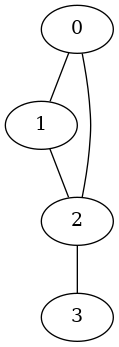

Step #1


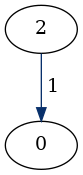

Step #2


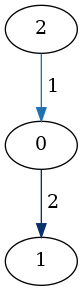

Step #3


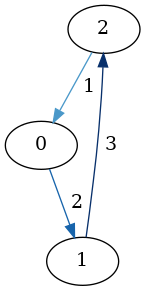

Step #4


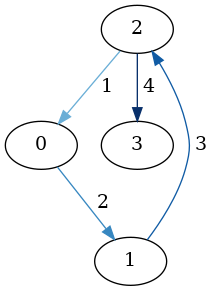

In [172]:
Ex = nx.Graph()
Ex.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3)])
fleury(Ex)

In [367]:
def run(graph, fun):
    try:
        fun(graph)
    except TooManyOddNodes as exc:
        print(str(exc))
    except NotConnectedGraph:
        print("Graph is not connected, algorithm will be applied on single connected components")
        for nodes in list(nx.connected_components(graph)):
            print("-------------------------------")
            print("Connected component: " + str(nodes))
            conn_comp_graph = nx.subgraph(graph, nodes)
            if len(nodes) <= 2:
                print("Connected component has just 2 nodes, Eulerian trail is trivial")
            else:
                try:
                    fun(conn_comp_graph)
                except TooManyOddNodes as exc:
                    print("This connected component will be skipped")
                    print(str(exc))

Graph is not connected, algorithm will be applied on single connected components
-------------------------------
Connected component: {'Messina', 'Reggio di Calabria', 'Enna', 'Palermo', 'Cosenza', 'Ragusa', 'Vibo Valentia', 'Agrigento', 'Catanzaro', 'Catania', 'Caltanissetta', 'Crotone', 'Siracusa'}
This connected component will be skipped
Graph has at least 3 nodes with odd degree: ['Messina', 'Palermo', 'Reggio di Calabria']
-------------------------------
Connected component: {'Cagliari', 'Sassari', 'Oristano', 'Sud Sardegna', 'Nuoro'}
Original graph


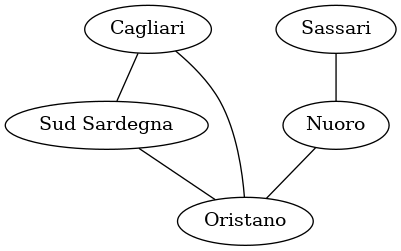

Step #1


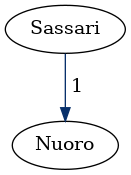

Step #2


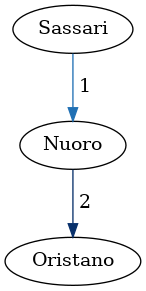

Step #3


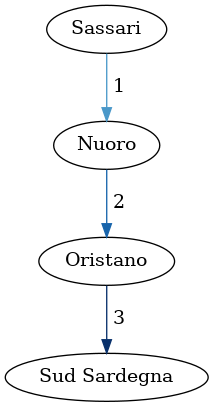

Step #4


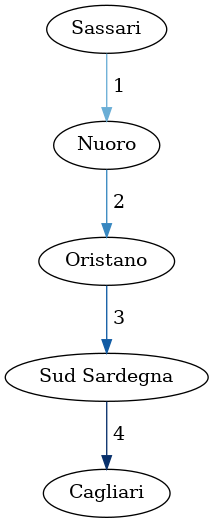

Step #5


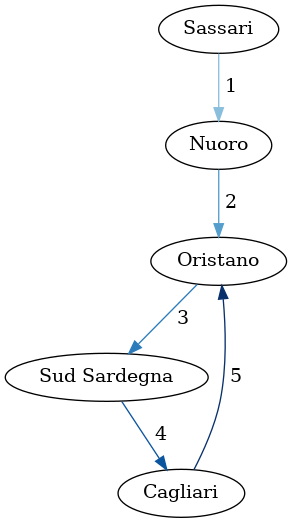

-------------------------------
Connected component: {'Viterbo', 'Novara', 'Verona', 'Savona', 'Bologna', 'Rieti', 'Pisa', 'Potenza', 'Biella', 'Como', 'Modena', "Reggio nell'Emilia", 'Foggia', 'Taranto', 'Ravenna', 'Mantova', 'Piacenza', 'Latina', 'Lucca', 'Vicenza', 'Vercelli', 'Napoli', 'Gorizia', 'Lecco', 'Bolzano', 'Campobasso', 'Torino', 'Firenze', 'Forlì-Cesena', 'Trento', 'Massa Carrara', 'Caserta', 'Roma', 'Pesaro e Urbino', 'Lecce', 'La Spezia', 'Varese', "L'Aquila", 'Imperia', 'Cuneo', 'Macerata', 'Venezia', 'Belluno', 'Ancona', 'Barletta-Andria-Trani', 'Pavia', 'Ascoli Piceno', 'Monza e della Brianza', 'Milano', 'Pistoia', 'Frosinone', 'Sondrio', 'Chieti', 'Verbano-Cusio-Ossola', 'Bergamo', 'Trieste', 'Asti', 'Rimini', 'Prato', 'Brindisi', 'Parma', 'Rovigo', 'Cremona', 'Bari', 'Avellino', 'Teramo', 'Benevento', 'Treviso', 'Ferrara', 'Pordenone', 'Genova', 'Arezzo', 'Udine', 'Terni', 'Lodi', 'Fermo', 'Isernia', 'Grosseto', 'Livorno', 'Brescia', 'Padova', 'Salerno', 'Alessand

In [368]:
run(P, fleury)

Graph is not connected, algorithm will be applied on single connected components
-------------------------------
Connected component: {'(30.01860835143052, 30.01860835143052)', '(30.090796842299913, 30.090796842299913)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.143104419370093, 30.143104419370093)', '(30.109637042301124, 30.109637042301124)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.13969433583976, 30.13969433583976)', '(30.15058203436334, 30.15058203436334)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.259700637385464, 30.259700637385464)', '(30.196737443500446, 30.196737443500446)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.318324969434848, 30.318324969434848)', '(3

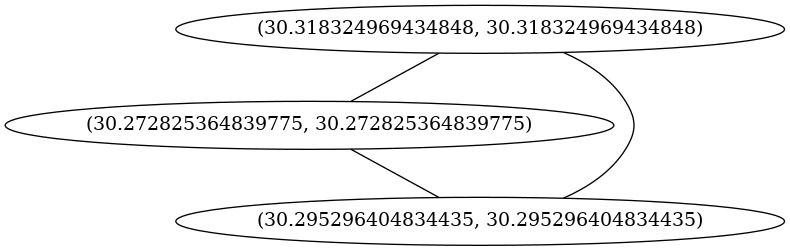

Step #1


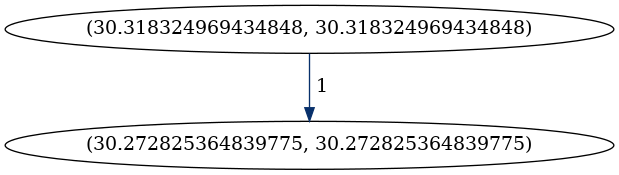

Step #2


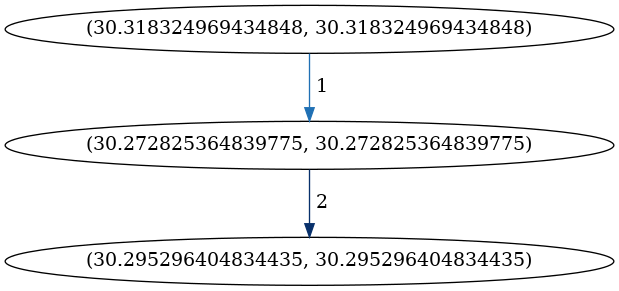

Step #3


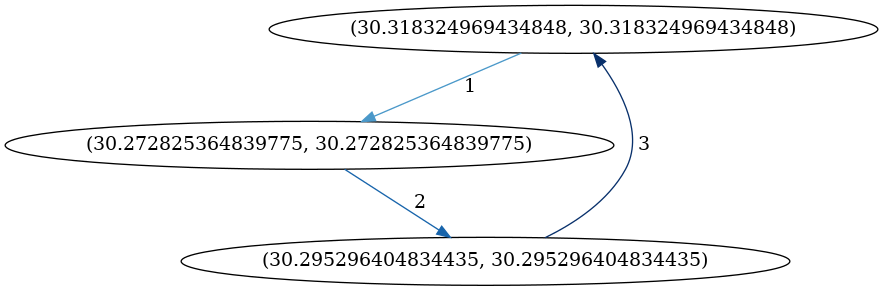

-------------------------------
Connected component: {'(30.363846962446033, 30.363846962446033)', '(30.30833044821162, 30.30833044821162)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.442012455061334, 30.442012455061334)', '(30.440858747420315, 30.440858747420315)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.450717402701123, 30.450717402701123)', '(30.428476334863515, 30.428476334863515)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.49267049092148, 30.49267049092148)', '(30.63926885767681, 30.63926885767681)', '(30.56008349098615, 30.56008349098615)'}
Original graph


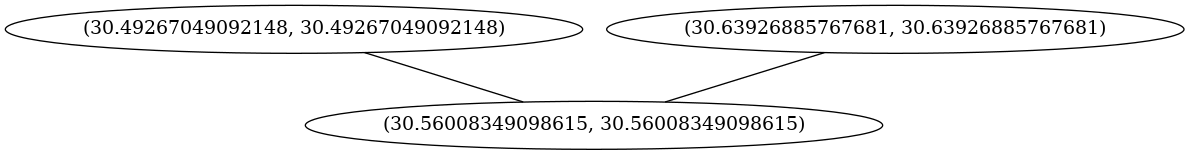

Step #1


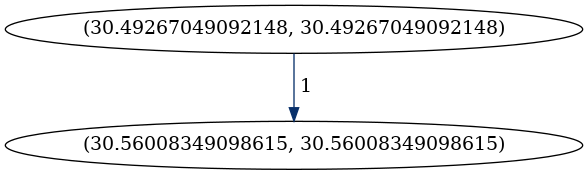

Step #2


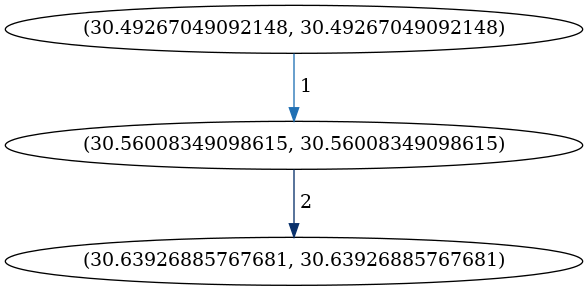

-------------------------------
Connected component: {'(30.750134913001336, 30.750134913001336)', '(30.816530507114784, 30.816530507114784)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.90545183014022, 30.90545183014022)', '(30.878977176871693, 30.878977176871693)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.880852208416613, 30.880852208416613)', '(30.905709523566266, 30.905709523566266)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.032067681305872, 31.032067681305872)', '(31.038144145029335, 31.038144145029335)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.036260114679973, 31.036260114679973)', '(31.100164910664333, 31.100164910664333)'}
Connected component has just 2 nodes

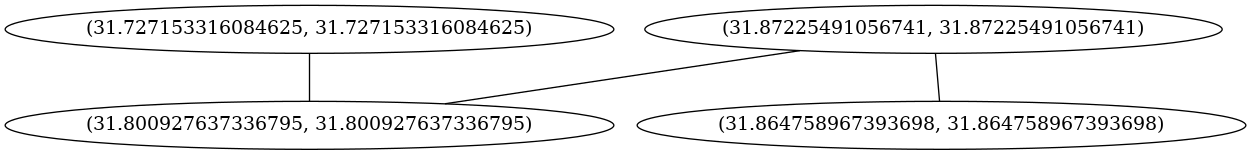

Step #1


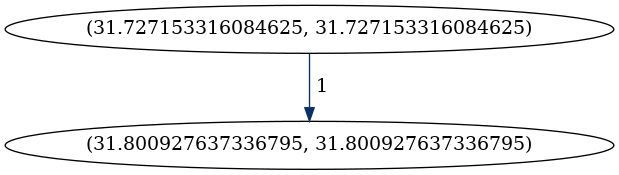

Step #2


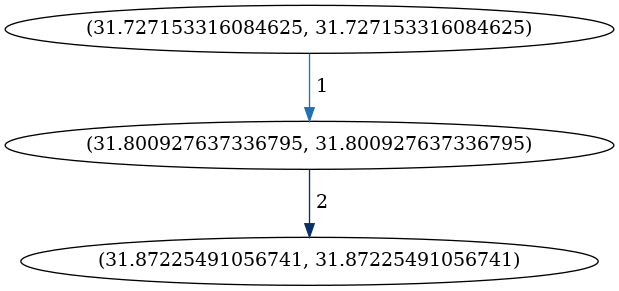

Step #3


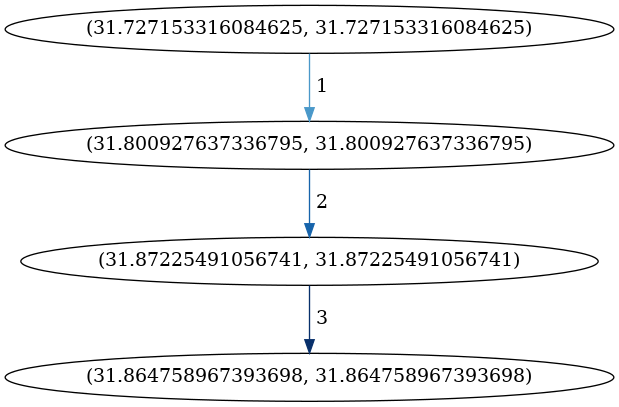

-------------------------------
Connected component: {'(31.80711467291952, 31.80711467291952)', '(31.806866916171444, 31.806866916171444)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.808564601927095, 31.808564601927095)', '(31.825498300178715, 31.825498300178715)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.82566847957699, 31.82566847957699)', '(31.75387030950945, 31.75387030950945)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.860883394847168, 31.860883394847168)', '(31.846235139198562, 31.846235139198562)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(32.02311654431249, 32.02311654431249)', '(31.961614881298694, 31.961614881298694)'}
Connected component has just 2 nodes, Eule

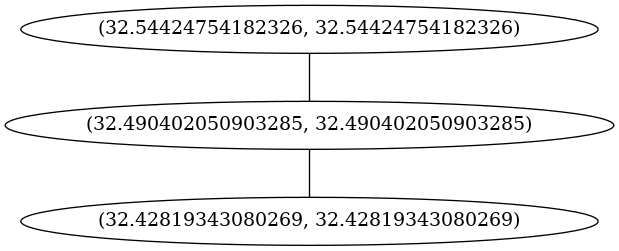

Step #1


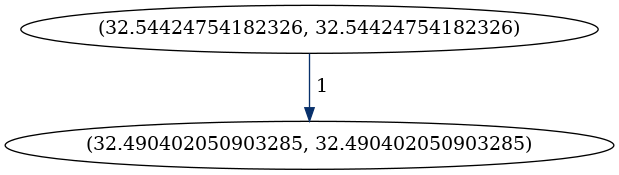

Step #2


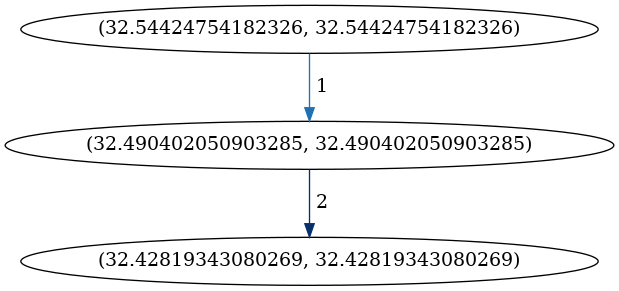

-------------------------------
Connected component: {'(32.62360335860146, 32.62360335860146)', '(32.55379538603918, 32.55379538603918)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(32.74162456332777, 32.74162456332777)', '(32.730002799746266, 32.730002799746266)', '(32.667855884274054, 32.667855884274054)'}
Original graph


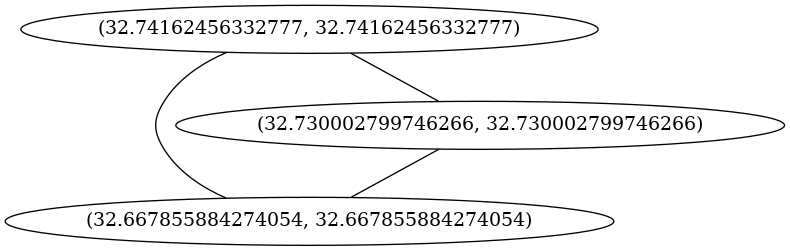

Step #1


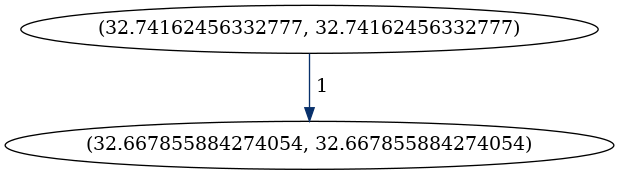

Step #2


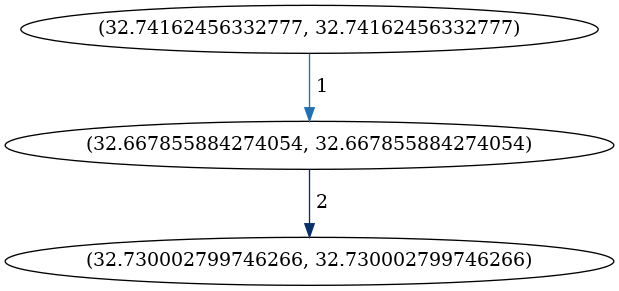

Step #3


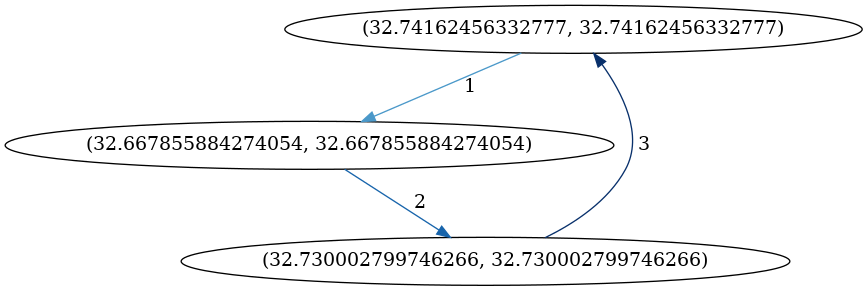

-------------------------------
Connected component: {'(32.83898368924655, 32.83898368924655)', '(32.812148409573304, 32.812148409573304)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(33.12611145699206, 33.12611145699206)', '(33.13104640361046, 33.13104640361046)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(33.12675005062142, 33.12675005062142)', '(33.16122525516479, 33.16122525516479)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(33.4090346210211, 33.4090346210211)', '(33.399379720530945, 33.399379720530945)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(33.53445249007793, 33.53445249007793)', '(33.53635512160151, 33.53635512160151)'}
Connected component has just 2 nodes, Eulerian trail

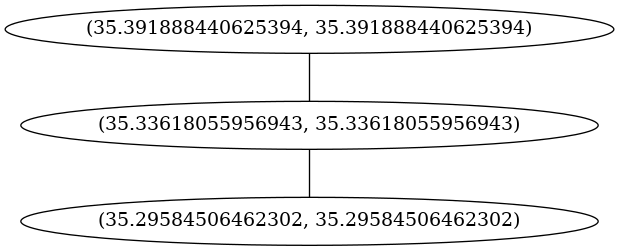

Step #1


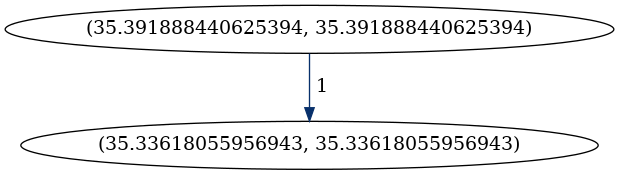

Step #2


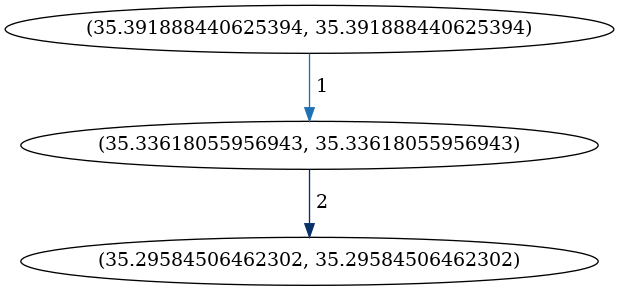

-------------------------------
Connected component: {'(35.344228718816495, 35.344228718816495)', '(35.3367659997433, 35.3367659997433)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(35.40042411616274, 35.40042411616274)', '(35.44825311071325, 35.44825311071325)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(35.44803199299912, 35.44803199299912)', '(35.4805823335263, 35.4805823335263)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(35.59006115533724, 35.59006115533724)', '(35.60410478965573, 35.60410478965573)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(35.6298782970006, 35.6298782970006)', '(35.615392064027716, 35.615392064027716)'}
Connected component has just 2 nodes, Eulerian trail is 

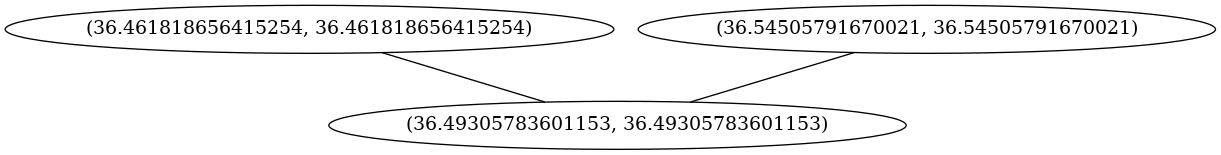

Step #1


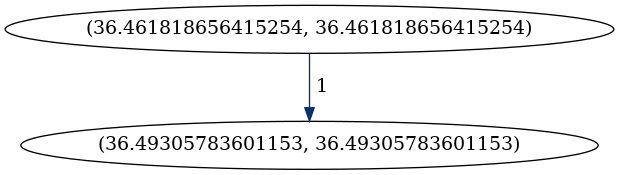

Step #2


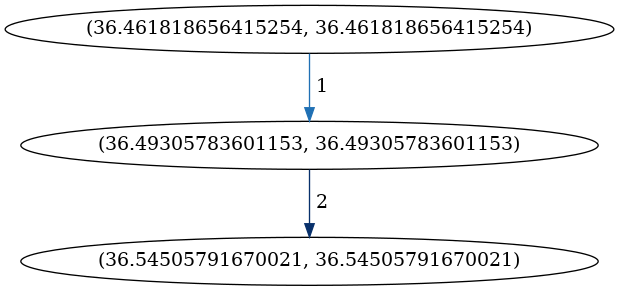

-------------------------------
Connected component: {'(36.49091635672396, 36.49091635672396)', '(36.56036972195428, 36.56036972195428)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(36.765567631059106, 36.765567631059106)', '(36.75657156526611, 36.75657156526611)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(36.833198466424406, 36.833198466424406)', '(36.8536213899148, 36.8536213899148)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(36.86977975335485, 36.86977975335485)', '(36.88007726497611, 36.88007726497611)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(36.97619468309686, 36.97619468309686)', '(36.90755741507972, 36.90755741507972)'}
Connected component has just 2 nodes, Eulerian trail

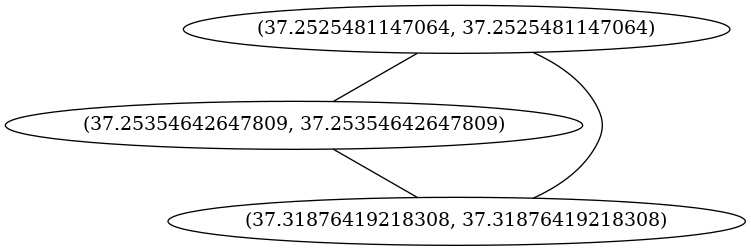

Step #1


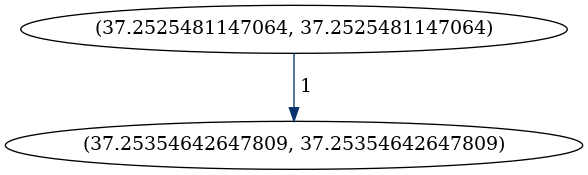

Step #2


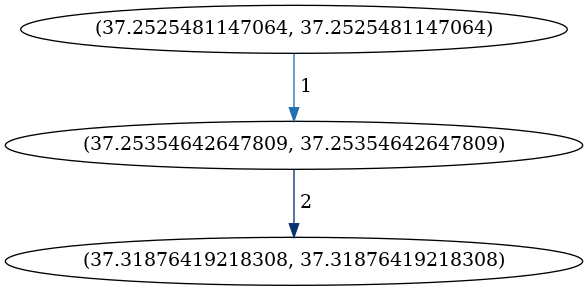

Step #3


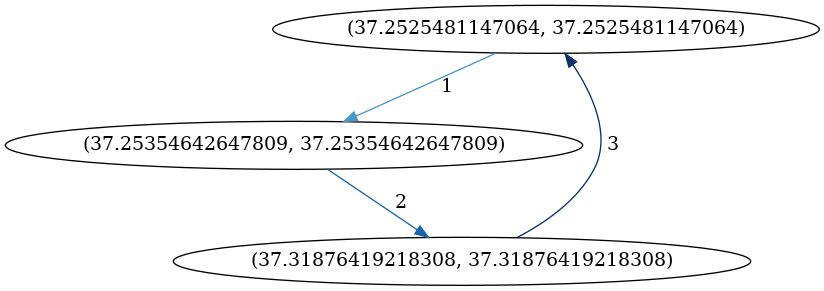

-------------------------------
Connected component: {'(37.29098881052466, 37.29098881052466)', '(37.3316534339572, 37.3316534339572)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(37.47745000461053, 37.47745000461053)', '(37.443944850708164, 37.443944850708164)', '(37.365561969525444, 37.365561969525444)'}
Original graph


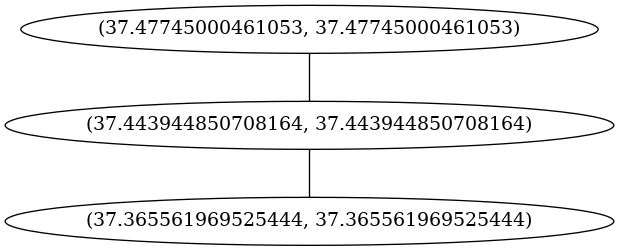

Step #1


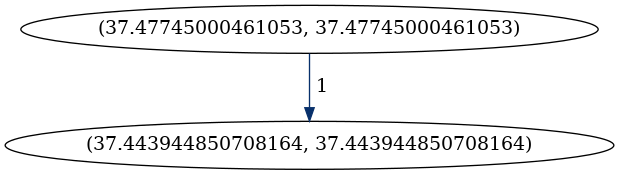

Step #2


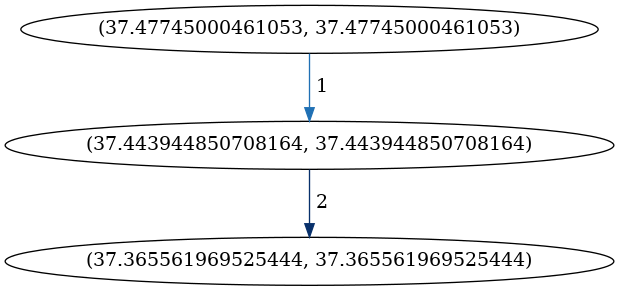

-------------------------------
Connected component: {'(37.868997108141805, 37.868997108141805)', '(37.83329551194229, 37.83329551194229)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.1033684718567, 38.1033684718567)', '(38.15649490295313, 38.15649490295313)', '(38.10740660676044, 38.10740660676044)'}
Original graph


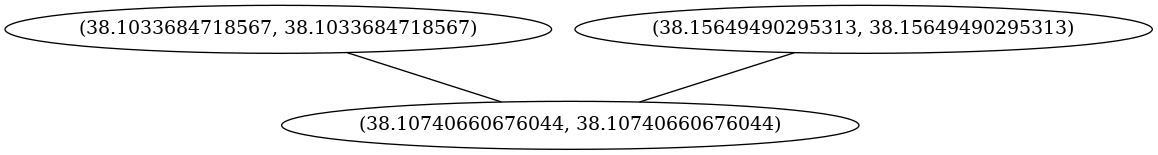

Step #1


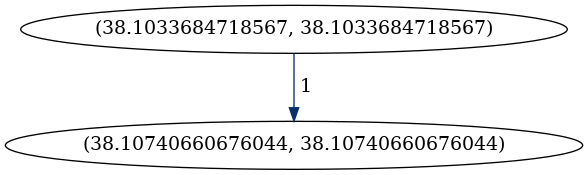

Step #2


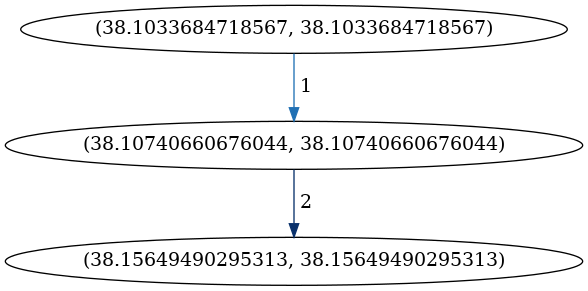

-------------------------------
Connected component: {'(38.211422763524226, 38.211422763524226)', '(38.142706508455085, 38.142706508455085)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.25090553299638, 38.25090553299638)', '(38.29532987637535, 38.29532987637535)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.2329887932273, 38.2329887932273)', '(38.308965925039104, 38.308965925039104)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.35059172056717, 38.35059172056717)', '(38.38120479634288, 38.38120479634288)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.332671176446205, 38.332671176446205)', '(38.39887143955712, 38.39887143955712)'}
Connected component has just 2 nodes, Eulerian t

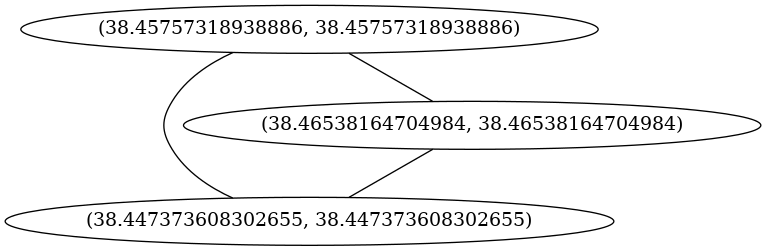

Step #1


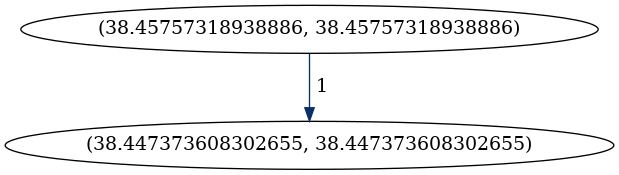

Step #2


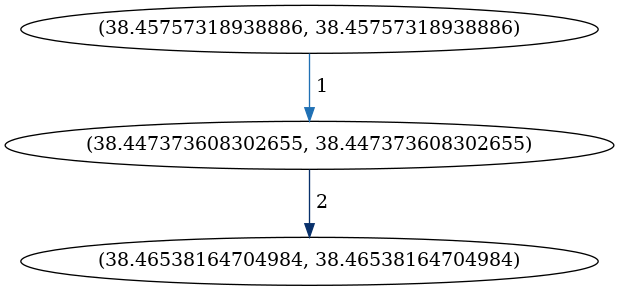

Step #3


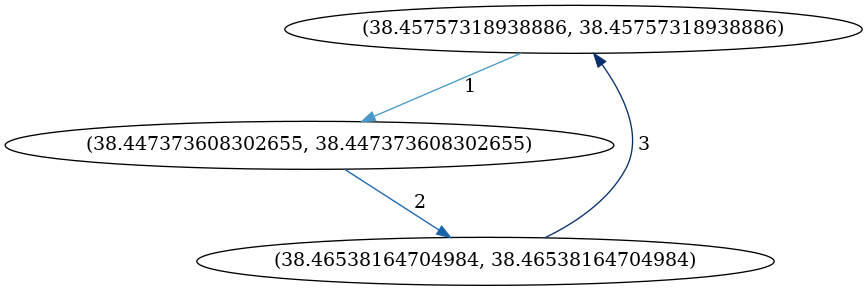

-------------------------------
Connected component: {'(38.74148015944414, 38.74148015944414)', '(38.713232775676246, 38.713232775676246)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(39.082557780124816, 39.082557780124816)', '(39.081945361328785, 39.081945361328785)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(39.21433639428483, 39.21433639428483)', '(39.15765562744217, 39.15765562744217)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(39.27317930857783, 39.27317930857783)', '(39.256923435971416, 39.256923435971416)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(39.358446088715795, 39.358446088715795)', '(39.414541146817115, 39.414541146817115)'}
Connected component has just 2 nodes, Eule

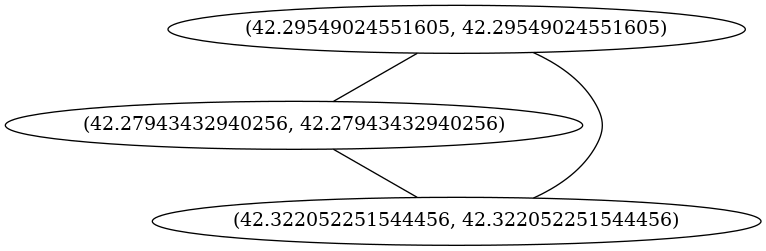

Step #1


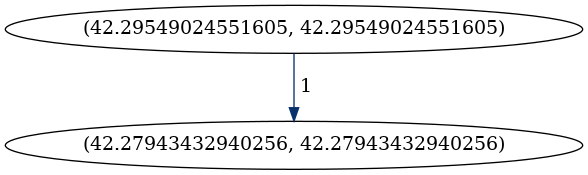

Step #2


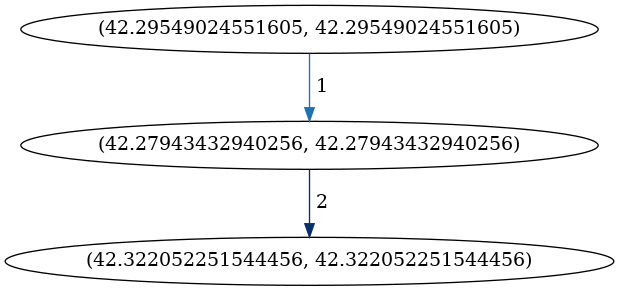

Step #3


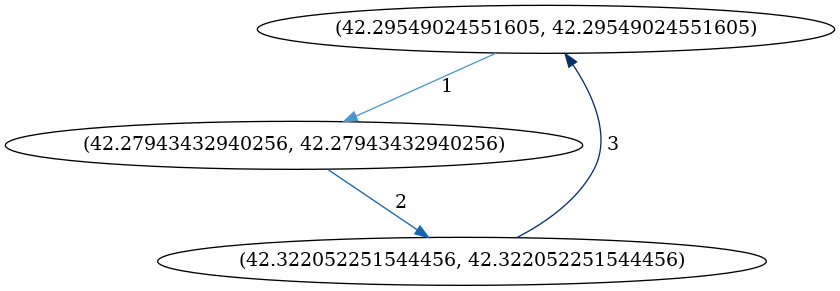

-------------------------------
Connected component: {'(42.361692152835886, 42.361692152835886)', '(42.323819220164225, 42.323819220164225)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(42.56305085329829, 42.56305085329829)', '(42.58727531296207, 42.58727531296207)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(42.85512655573666, 42.85512655573666)', '(42.862045087959245, 42.862045087959245)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(43.00503951846617, 43.00503951846617)', '(42.982054452496016, 42.982054452496016)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(43.10423272643871, 43.10423272643871)', '(43.0865010030059, 43.0865010030059)'}
Connected component has just 2 nodes, Eulerian t

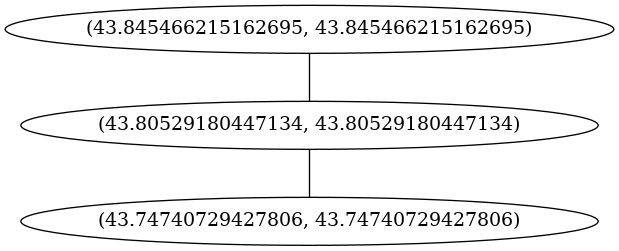

Step #1


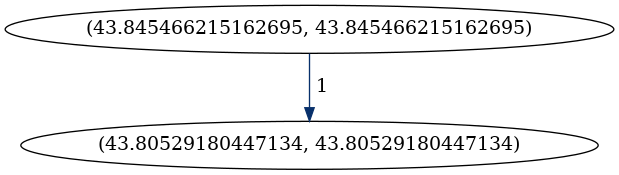

Step #2


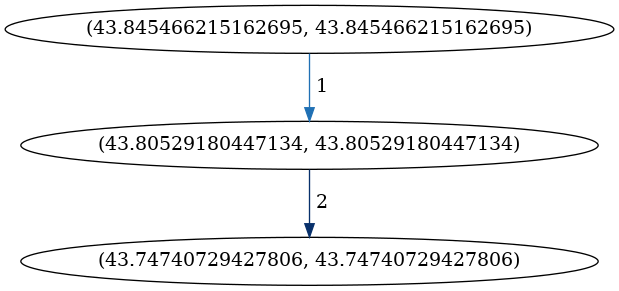

-------------------------------
Connected component: {'(43.81117244549021, 43.81117244549021)', '(43.78412549488373, 43.78412549488373)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(43.82347833146514, 43.82347833146514)', '(43.757434790830565, 43.757434790830565)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(43.940741893266164, 43.940741893266164)', '(43.97564841691283, 43.97564841691283)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(44.04673681896151, 44.04673681896151)', '(43.995347735144364, 43.995347735144364)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(44.26784616193072, 44.26784616193072)', '(44.33791929204463, 44.33791929204463)'}
Connected component has just 2 nodes, Eulerian t

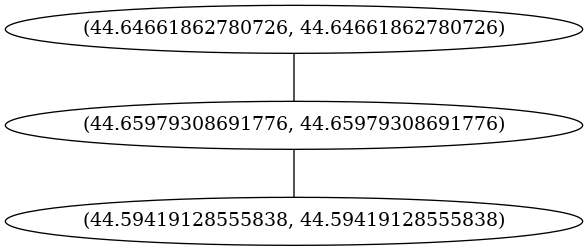

Step #1


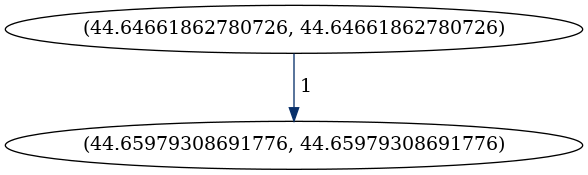

Step #2


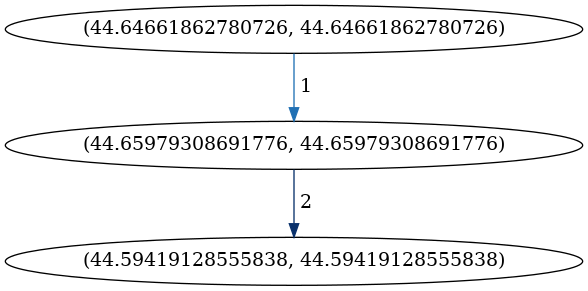

-------------------------------
Connected component: {'(44.677040255434214, 44.677040255434214)', '(44.66833124711898, 44.66833124711898)', '(44.61333836039748, 44.61333836039748)'}
Original graph


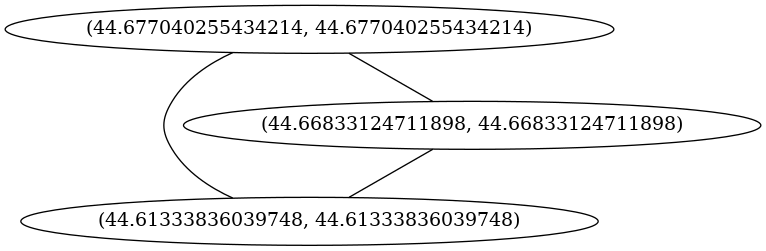

Step #1


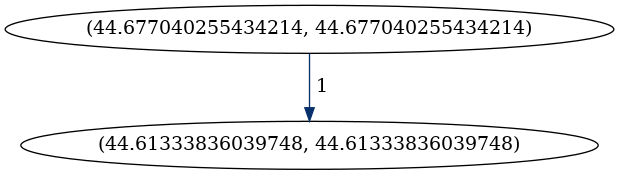

Step #2


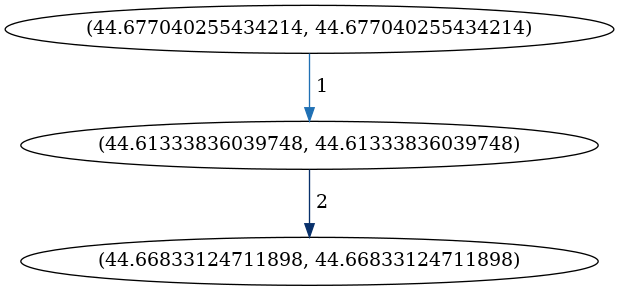

Step #3


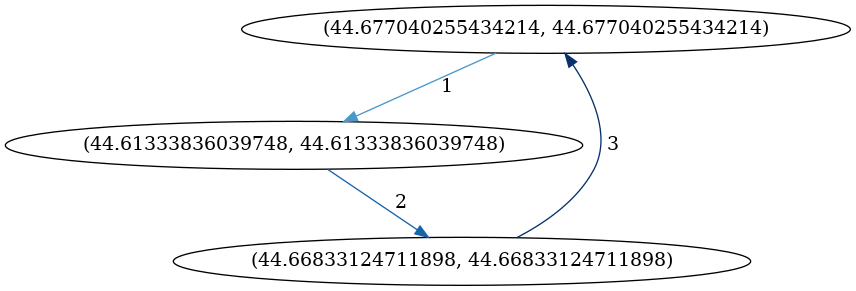

-------------------------------
Connected component: {'(44.97288934365913, 44.97288934365913)', '(44.97213340646316, 44.97213340646316)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.080503824176944, 45.080503824176944)', '(45.01785711722693, 45.01785711722693)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.09429798922837, 45.09429798922837)', '(45.024560487527246, 45.024560487527246)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.088174897894255, 45.088174897894255)', '(45.127367817625995, 45.127367817625995)', '(45.15410072357035, 45.15410072357035)', '(45.123079722888306, 45.123079722888306)'}
Original graph


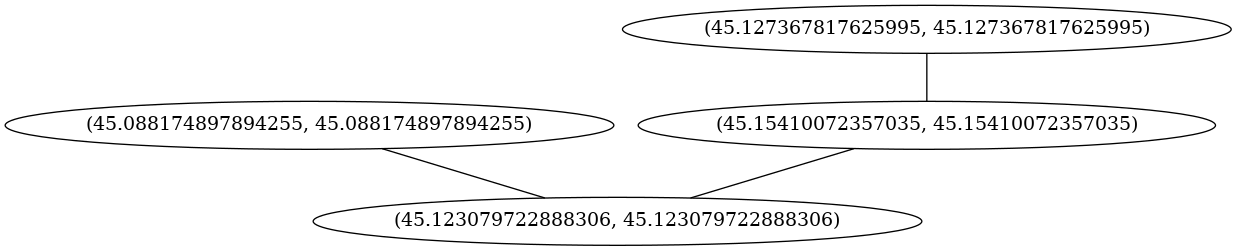

Step #1


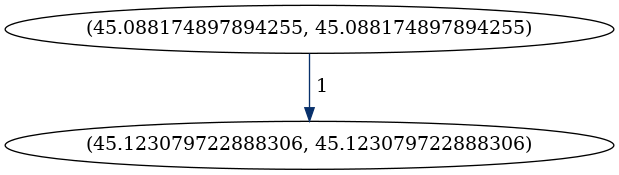

Step #2


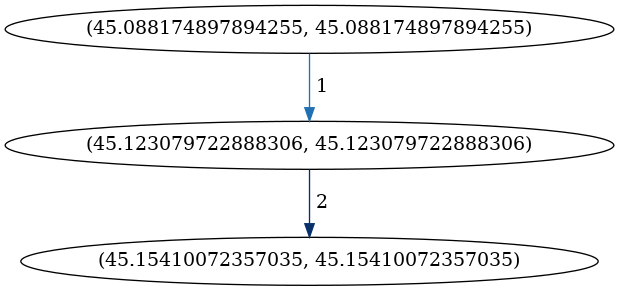

Step #3


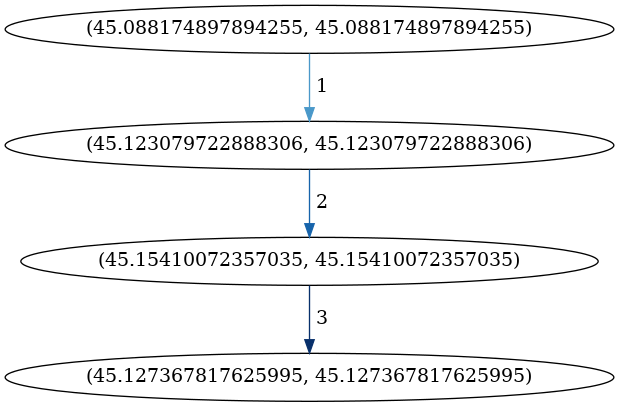

-------------------------------
Connected component: {'(45.119041289229585, 45.119041289229585)', '(45.17799419635142, 45.17799419635142)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.26602822585145, 45.26602822585145)', '(45.22443251825489, 45.22443251825489)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.42938111950895, 45.42938111950895)', '(45.383167680296076, 45.383167680296076)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.575820027412384, 45.575820027412384)', '(45.50301459259976, 45.50301459259976)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.89814584386543, 45.89814584386543)', '(45.94159565977925, 45.94159565977925)'}
Connected component has just 2 nodes, Eulerian t

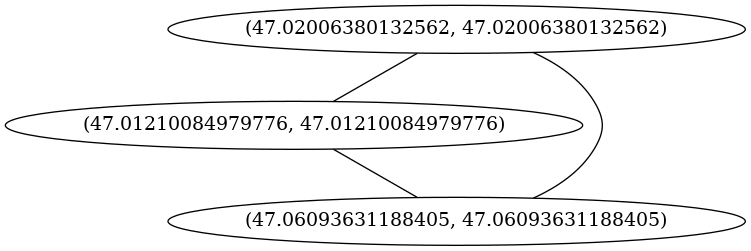

Step #1


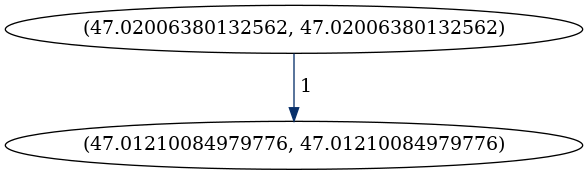

Step #2


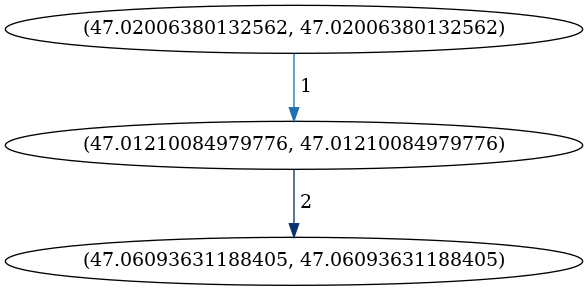

Step #3


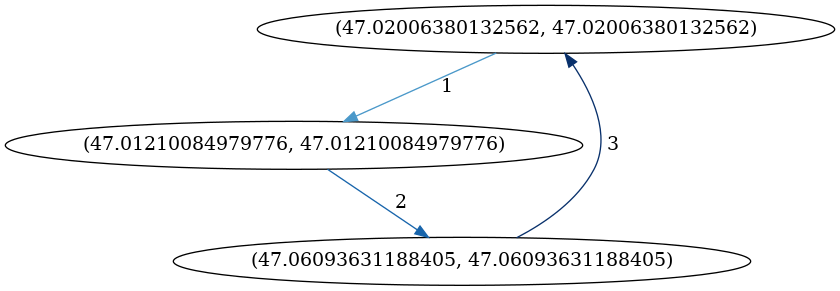

-------------------------------
Connected component: {'(47.06959705434048, 47.06959705434048)', '(47.04843626891003, 47.04843626891003)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(47.218865354677945, 47.218865354677945)', '(47.17968855801409, 47.17968855801409)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(47.25860525355858, 47.25860525355858)', '(47.26754862781722, 47.26754862781722)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(47.29384130116835, 47.29384130116835)', '(47.349602673958685, 47.349602673958685)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(47.39822428047691, 47.39822428047691)', '(47.33938819241884, 47.33938819241884)'}
Connected component has just 2 nodes, Eulerian tra

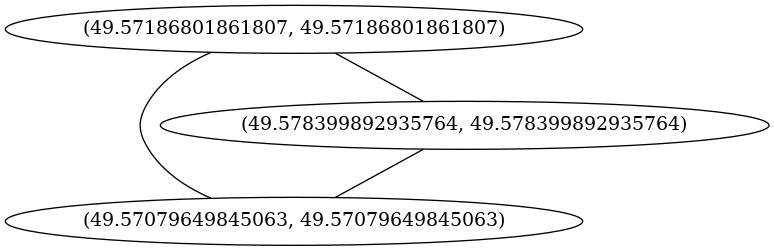

Step #1


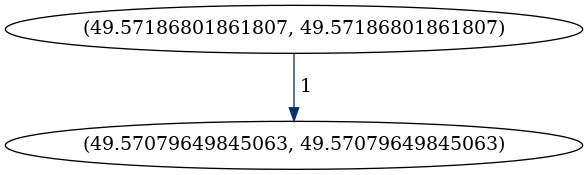

Step #2


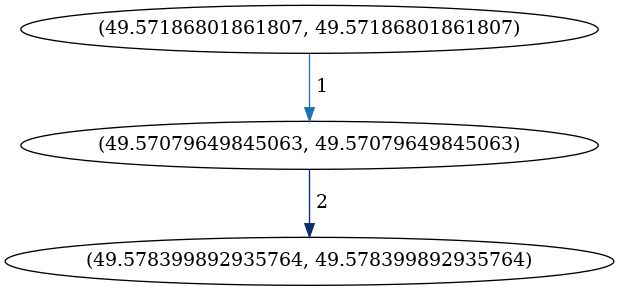

Step #3


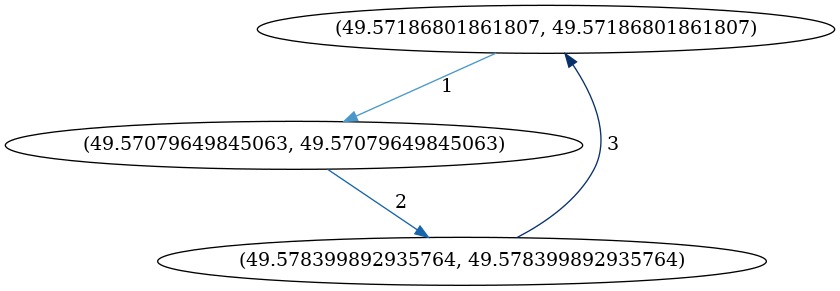

-------------------------------
Connected component: {'(49.633397199009764, 49.633397199009764)', '(49.71473189541066, 49.71473189541066)', '(49.655650096311675, 49.655650096311675)'}
Original graph


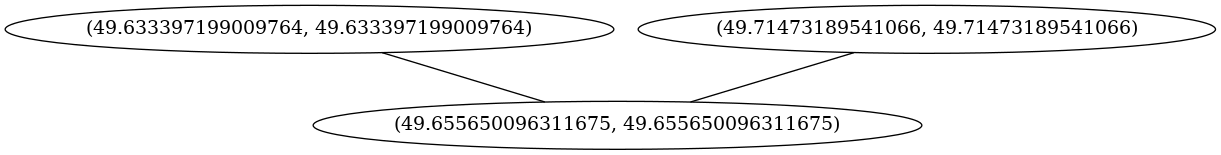

Step #1


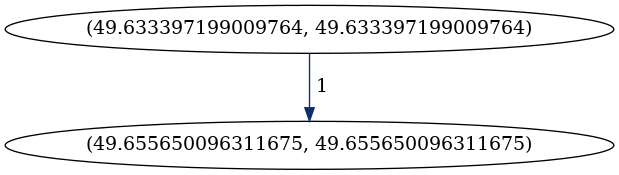

Step #2


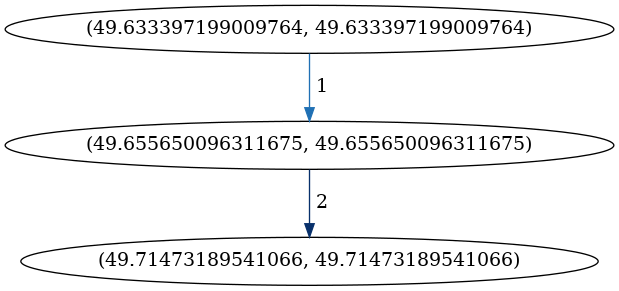

-------------------------------
Connected component: {'(49.7634696948062, 49.7634696948062)', '(49.797674083525834, 49.797674083525834)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(49.81009597611238, 49.81009597611238)', '(49.844104512527416, 49.844104512527416)', '(49.793480424513874, 49.793480424513874)'}
Original graph


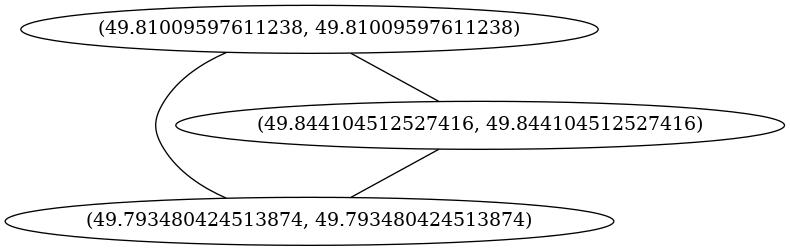

Step #1


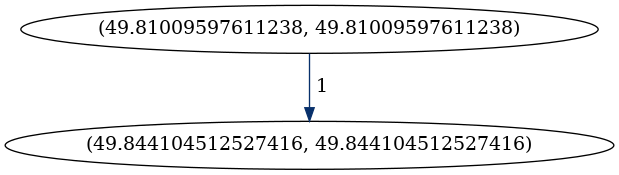

Step #2


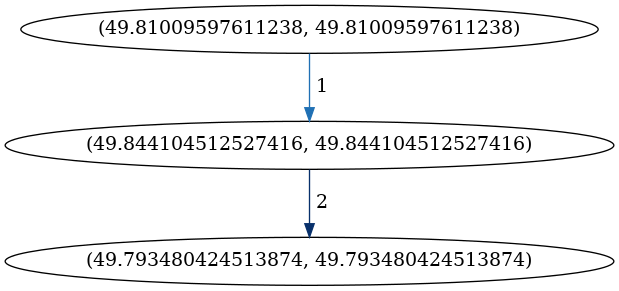

Step #3


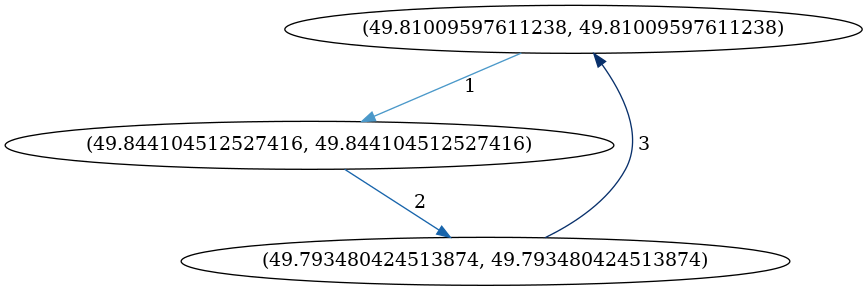

-------------------------------
Connected component: {'(49.82175679599748, 49.82175679599748)', '(49.79340557785643, 49.79340557785643)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(49.836726326952224, 49.836726326952224)', '(49.774997692483424, 49.774997692483424)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(49.88336296278086, 49.88336296278086)', '(49.818839507846675, 49.818839507846675)', '(49.8648548852878, 49.8648548852878)'}
Original graph


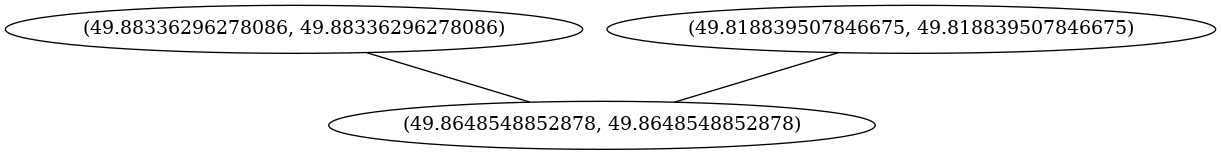

Step #1


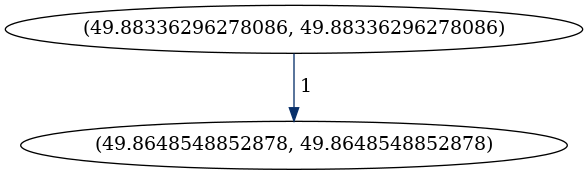

Step #2


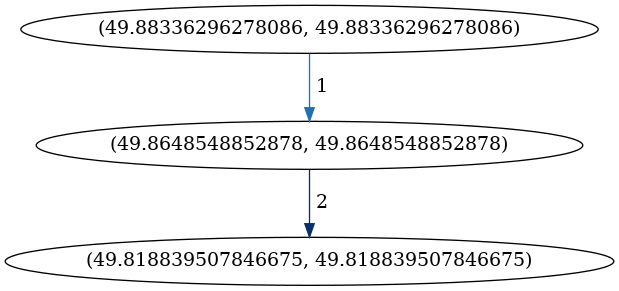

In [369]:
run(R, fleury)

## Hierholzer's algorithm
Hierholzer's is more efficient than Fleury's algorithm:
  1. Choose any starting vertex v
  2. Follow a trail of edges from that vertex until returning to v.  
      It is not possible to get stuck at any vertex other than v, because the even degree of all vertices ensures that, when the trail enters another vertex w there must be an unused edge leaving w. The tour formed in this way is a closed tour, but may not cover all the vertices and edges of the initial graph.
  3. As long as there exists a vertex u that belongs to the current tour but that has adjacent edges not part of the tour, start another trail from u, following unused edges until returning to u, and join the tour formed in this way to the previous tour.

Since we assume the original graph is connected, repeating the previous step will exhaust all edges of the graph.
If 

## Utility Class Double Linked List
In this way add and pop at begin or end will cost $\mathcal{\Theta}\ (\ 1\ )$

In [376]:
class Node:
    def __init__(self, initdata):
        self.data = initdata
        self.next = None
        self.prev = None

    def getData(self):
        return self.data

    def getNext(self):
        return self.next
    
    def getPrev(self):
        return self.prev

    def setData(self,newdata):
        self.data = newdata

    def setNext(self, next):
        self.next = next
        
    def setPrev(self, prev):
        self.prev = prev
        
    def __str__(self):
        return str(self.data)
        
class DoubleLinkedList:
    def __init__(self):
        self.head = None
        self.tail = None
        
    def __iter__(self):
        return DoubleLinkedListIterator(self)

    def isEmpty(self):
        return self.head == None
    
    def add_begin(self, item):
        temp = Node(item)
        if self.isEmpty():
            self.tail = temp
        else:
            self.head.setPrev(temp)
            temp.setNext(self.head)            
        self.head = temp
        
    def add_end(self, item):
        temp = Node(item)
        if self.isEmpty():
            self.head = temp
        else:
            self.tail.setNext(temp)
            temp.setPrev(self.tail)
        self.tail = temp
        
    def pop_begin(self):
        temp = self.head
        self.head = temp.next
        # If list is empty after pop
        if self.head == None:
            self.tail = None
        else:
            self.head.setPrev(None)
        return temp.getData()
        
    def pop_end(self):
        temp = self.tail
        self.tail = temp.prev
        # If list is empty after pop
        if self.tail == None:
            self.head = None
        else:
            self.tail.setNext(None)
        return temp.getData()
        
    def __str__(self):
        ret_str = "head --> "
        for node in self:
            if ret_str != "head --> ":
                ret_str += " <--> "
            ret_str += str(node)
        ret_str += " <-- tail"
        return ret_str
            
class DoubleLinkedListIterator:
    def __init__(self, doubleLinkedList):
        self.doubleLinkedList = doubleLinkedList
        self.pointer = doubleLinkedList.head
        
    def __next__(self):
        if self.pointer == None:
            raise StopIteration
        else:
            node = self.pointer
            self.pointer = self.pointer.next
            return node

In [371]:
def hierholzer(graph, viz = True):
    # Directed Graph that will contain Eulerian path
    trail = nx.DiGraph()
    
    # Double Linked List that will contain current path
    curr_path = DoubleLinkedList()
    
    # Check if graph is connected
    if not nx.is_connected(graph):
        raise NotConnectedGraph("Graph is not connected")

    # Use of tmpGraph to leave graph as received
    tmpGraph = graph.copy()
    
    # Check which nodes have odd degree and raise exception if more than 2 have been found
    odd_degree_nodes = []
    for node in tmpGraph.nodes:
        if tmpGraph.degree(node) % 2 != 0:
            odd_degree_nodes.append(node)
            if len(odd_degree_nodes) > 2:
                raise TooManyOddNodes("Graph has at least 3 nodes with odd degree: " + str(odd_degree_nodes))            
    
    print("Original graph")
    if viz:
        draw_graph_viz(graph)
    else:
        draw_graph(graph, figsize = (6, 6))
        
    # Start with an odd node (if any)
    if len(odd_degree_nodes) > 0:
        node = odd_degree_nodes[0]
    else:
        node = [*tmpGraph.nodes][0]
    
    end = False
    order = 1
    curr_path.add_end(node)
    prev_node = None
    while not end:
        print("Step #" + str(order))            
        # If node has at least 1 neighbour
        if len(tmpGraph[node]) > 0:
            next_node = [*tmpGraph[node]][0]
            
        else:
            # If we visited all edges we just need to add to DiGraph
            # all edges from curr_path
            if len(tmpGraph.edges()) == 0:
                end = True
                while not curr_path.isEmpty():
                    node = curr_path.pop_end()
                    trail.add_node(node)
                    if prev_node != None:
                        trail.add_edge(prev_node, node, order = len(trail.edges()) + 1)
                    prev_node = node
            # If there are still some edges in the Graph
            else:
                found = False
                end = True
                # We search within all already visited nodes in curr_path
                while not curr_path.isEmpty() and not found:
                    node = curr_path.pop_end()
                    # If extracted node from curr_path has at least a non-visited edge
                    # we set that node as next_node
                    if len(tmpGraph[node]) > 0:
                        next_node = [*tmpGraph[node]][0]
                        curr_path.add_end(node)
                        found = True
                        end = False
                    # Otherwise we add that node to trail
                    else:
                        if prev_node == None:
                            prev_node = node
                            trail.add_node(prev_node)
                        else:
                            trail.add_edge(prev_node, node, order = len(trail.edges()) + 1)                
                            prev_node = node
        
        if not end:
            tmpGraph.remove_edge(node, next_node)
            curr_path.add_end(next_node)
            node = next_node
        
        print("Curr Path: " + str(curr_path))
        if viz:
            draw_graph_viz(trail, "order")
        else:
            draw_graph(trail, "order")
        order = order + 1    

Original graph


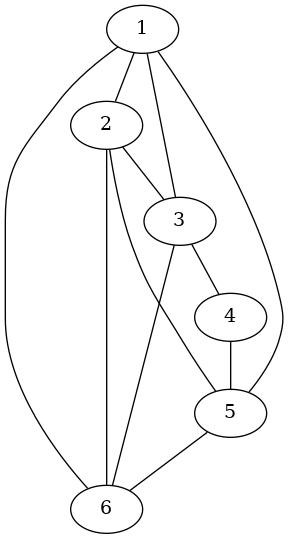

Step #1
Curr Path: head --> 1 <--> 2 <-- tail


Step #2
Curr Path: head --> 1 <--> 2 <--> 5 <-- tail


Step #3
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <-- tail


Step #4
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <--> 3 <-- tail


Step #5
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <--> 3 <--> 2 <-- tail


Step #6
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <--> 3 <--> 2 <--> 6 <-- tail


Step #7
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <--> 3 <--> 2 <--> 6 <--> 1 <-- tail


Step #8
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <--> 3 <--> 2 <--> 6 <--> 3 <-- tail


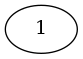

Step #9
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <--> 3 <--> 2 <--> 6 <--> 3 <--> 4 <-- tail


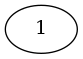

Step #10
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <--> 3 <--> 2 <--> 6 <--> 3 <--> 4 <--> 5 <-- tail


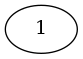

Step #11
Curr Path: head --> 1 <--> 2 <--> 5 <--> 1 <--> 3 <--> 2 <--> 6 <--> 3 <--> 4 <--> 5 <--> 6 <-- tail


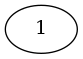

Step #12
Curr Path: head -->  <-- tail


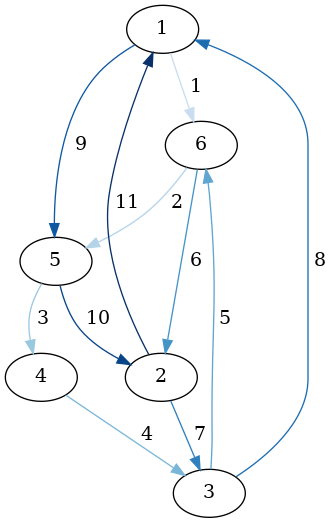

In [372]:
Ex = nx.Graph()
Ex.add_nodes_from(range(1, 7))
Ex.add_edges_from([(1, 2), (1, 3), (1, 5), (1, 6), (2, 5), (2, 6), (2, 3), (3, 6), (4, 3), (4, 5), (5, 6)])
hierholzer(Ex)

Original graph


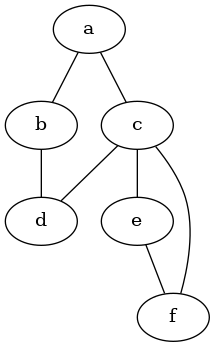

Step #1
Curr Path: head --> a <--> b <-- tail


Step #2
Curr Path: head --> a <--> b <--> d <-- tail


Step #3
Curr Path: head --> a <--> b <--> d <--> c <-- tail


Step #4
Curr Path: head --> a <--> b <--> d <--> c <--> a <-- tail


Step #5
Curr Path: head --> a <--> b <--> d <--> c <--> e <-- tail


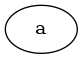

Step #6
Curr Path: head --> a <--> b <--> d <--> c <--> e <--> f <-- tail


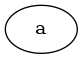

Step #7
Curr Path: head --> a <--> b <--> d <--> c <--> e <--> f <--> c <-- tail


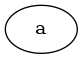

Step #8
Curr Path: head -->  <-- tail


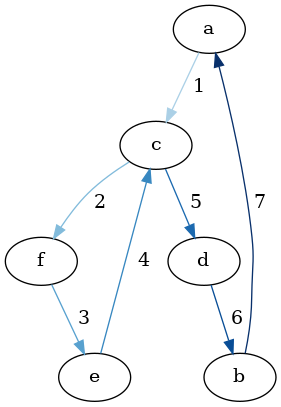

In [373]:
Ex = nx.Graph()
Ex.add_nodes_from("abcdef")
Ex.add_edges_from([('a', 'b'), ('a', 'c'), ('d', 'b'), ('d', 'c'), ('e', 'c'), ('e', 'f'), ('c', 'f')])
hierholzer(Ex)

Graph is not connected, algorithm will be applied on single connected components
-------------------------------
Connected component: {'Messina', 'Reggio di Calabria', 'Enna', 'Palermo', 'Cosenza', 'Ragusa', 'Vibo Valentia', 'Agrigento', 'Catanzaro', 'Catania', 'Caltanissetta', 'Crotone', 'Siracusa'}
This connected component will be skipped
Graph has at least 3 nodes with odd degree: ['Messina', 'Palermo', 'Reggio di Calabria']
-------------------------------
Connected component: {'Cagliari', 'Sassari', 'Oristano', 'Sud Sardegna', 'Nuoro'}
Original graph


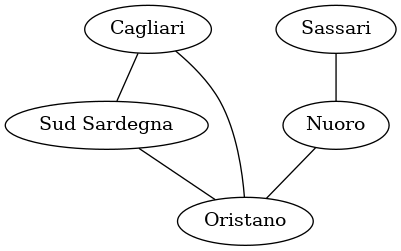

Step #1
Curr Path: head --> Sassari <--> Nuoro <-- tail


Step #2
Curr Path: head --> Sassari <--> Nuoro <--> Oristano <-- tail


Step #3
Curr Path: head --> Sassari <--> Nuoro <--> Oristano <--> Cagliari <-- tail


Step #4
Curr Path: head --> Sassari <--> Nuoro <--> Oristano <--> Cagliari <--> Sud Sardegna <-- tail


Step #5
Curr Path: head --> Sassari <--> Nuoro <--> Oristano <--> Cagliari <--> Sud Sardegna <--> Oristano <-- tail


Step #6
Curr Path: head -->  <-- tail


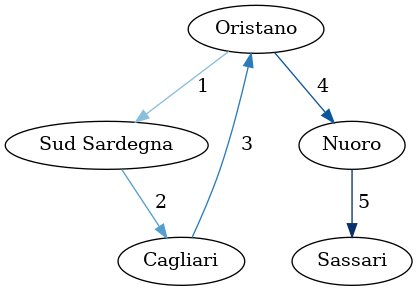

-------------------------------
Connected component: {'Viterbo', 'Novara', 'Verona', 'Savona', 'Bologna', 'Rieti', 'Pisa', 'Potenza', 'Biella', 'Como', 'Modena', "Reggio nell'Emilia", 'Foggia', 'Taranto', 'Ravenna', 'Mantova', 'Piacenza', 'Latina', 'Lucca', 'Vicenza', 'Vercelli', 'Napoli', 'Gorizia', 'Lecco', 'Bolzano', 'Campobasso', 'Torino', 'Firenze', 'Forlì-Cesena', 'Trento', 'Massa Carrara', 'Caserta', 'Roma', 'Pesaro e Urbino', 'Lecce', 'La Spezia', 'Varese', "L'Aquila", 'Imperia', 'Cuneo', 'Macerata', 'Venezia', 'Belluno', 'Ancona', 'Barletta-Andria-Trani', 'Pavia', 'Ascoli Piceno', 'Monza e della Brianza', 'Milano', 'Pistoia', 'Frosinone', 'Sondrio', 'Chieti', 'Verbano-Cusio-Ossola', 'Bergamo', 'Trieste', 'Asti', 'Rimini', 'Prato', 'Brindisi', 'Parma', 'Rovigo', 'Cremona', 'Bari', 'Avellino', 'Teramo', 'Benevento', 'Treviso', 'Ferrara', 'Pordenone', 'Genova', 'Arezzo', 'Udine', 'Terni', 'Lodi', 'Fermo', 'Isernia', 'Grosseto', 'Livorno', 'Brescia', 'Padova', 'Salerno', 'Alessand

In [374]:
run(P, hierholzer)

Graph is not connected, algorithm will be applied on single connected components
-------------------------------
Connected component: {'(30.01860835143052, 30.01860835143052)', '(30.090796842299913, 30.090796842299913)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.143104419370093, 30.143104419370093)', '(30.109637042301124, 30.109637042301124)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.13969433583976, 30.13969433583976)', '(30.15058203436334, 30.15058203436334)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.259700637385464, 30.259700637385464)', '(30.196737443500446, 30.196737443500446)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.318324969434848, 30.318324969434848)', '(3

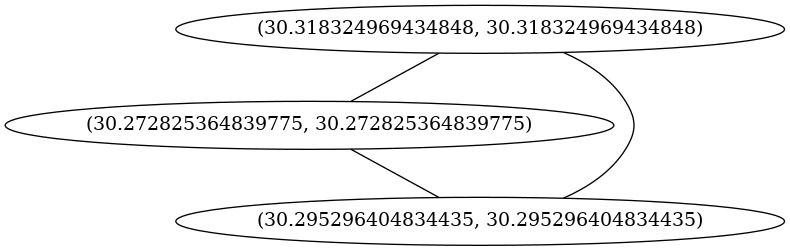

Step #1
Curr Path: head --> (30.318324969434848, 30.318324969434848) <--> (30.272825364839775, 30.272825364839775) <-- tail


Step #2
Curr Path: head --> (30.318324969434848, 30.318324969434848) <--> (30.272825364839775, 30.272825364839775) <--> (30.295296404834435, 30.295296404834435) <-- tail


Step #3
Curr Path: head --> (30.318324969434848, 30.318324969434848) <--> (30.272825364839775, 30.272825364839775) <--> (30.295296404834435, 30.295296404834435) <--> (30.318324969434848, 30.318324969434848) <-- tail


Step #4
Curr Path: head -->  <-- tail


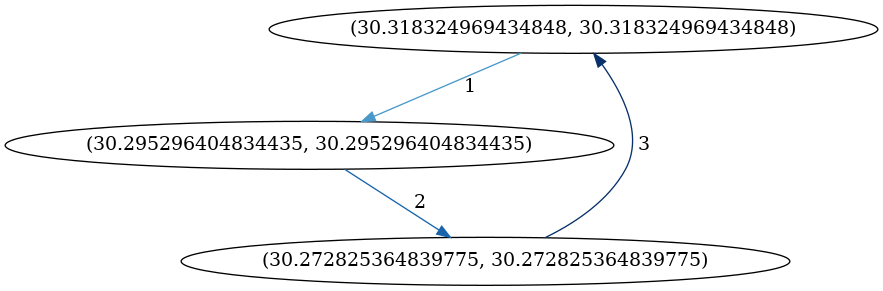

-------------------------------
Connected component: {'(30.363846962446033, 30.363846962446033)', '(30.30833044821162, 30.30833044821162)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.442012455061334, 30.442012455061334)', '(30.440858747420315, 30.440858747420315)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.450717402701123, 30.450717402701123)', '(30.428476334863515, 30.428476334863515)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.49267049092148, 30.49267049092148)', '(30.63926885767681, 30.63926885767681)', '(30.56008349098615, 30.56008349098615)'}
Original graph


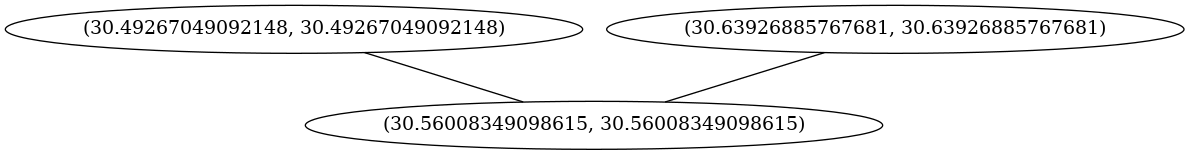

Step #1
Curr Path: head --> (30.49267049092148, 30.49267049092148) <--> (30.56008349098615, 30.56008349098615) <-- tail


Step #2
Curr Path: head --> (30.49267049092148, 30.49267049092148) <--> (30.56008349098615, 30.56008349098615) <--> (30.63926885767681, 30.63926885767681) <-- tail


Step #3
Curr Path: head -->  <-- tail


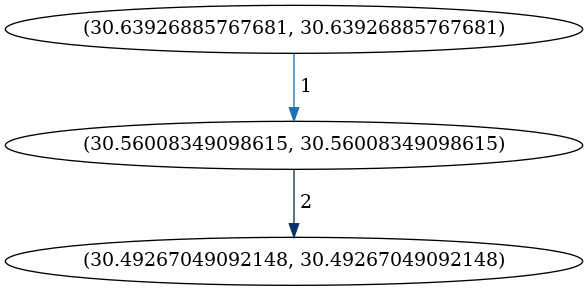

-------------------------------
Connected component: {'(30.750134913001336, 30.750134913001336)', '(30.816530507114784, 30.816530507114784)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.90545183014022, 30.90545183014022)', '(30.878977176871693, 30.878977176871693)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(30.880852208416613, 30.880852208416613)', '(30.905709523566266, 30.905709523566266)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.032067681305872, 31.032067681305872)', '(31.038144145029335, 31.038144145029335)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.036260114679973, 31.036260114679973)', '(31.100164910664333, 31.100164910664333)'}
Connected component has just 2 nodes

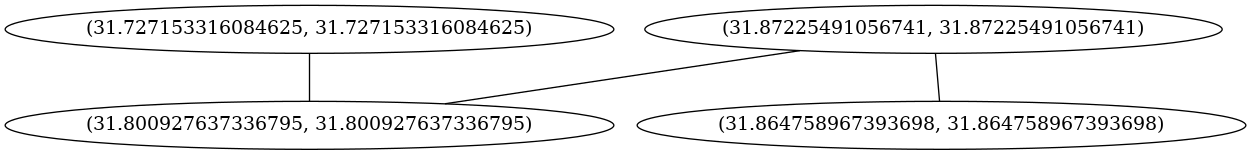

Step #1
Curr Path: head --> (31.727153316084625, 31.727153316084625) <--> (31.800927637336795, 31.800927637336795) <-- tail


Step #2
Curr Path: head --> (31.727153316084625, 31.727153316084625) <--> (31.800927637336795, 31.800927637336795) <--> (31.87225491056741, 31.87225491056741) <-- tail


Step #3
Curr Path: head --> (31.727153316084625, 31.727153316084625) <--> (31.800927637336795, 31.800927637336795) <--> (31.87225491056741, 31.87225491056741) <--> (31.864758967393698, 31.864758967393698) <-- tail


Step #4
Curr Path: head -->  <-- tail


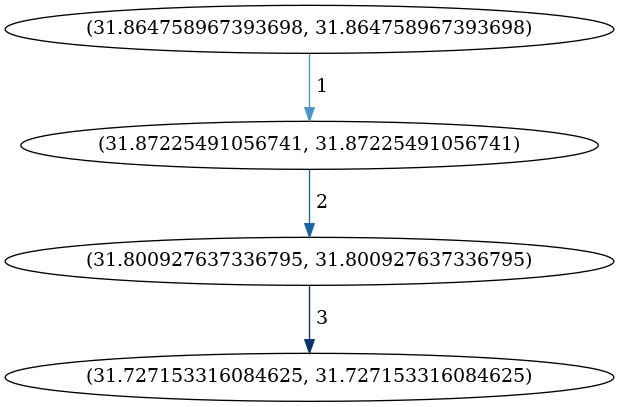

-------------------------------
Connected component: {'(31.80711467291952, 31.80711467291952)', '(31.806866916171444, 31.806866916171444)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.808564601927095, 31.808564601927095)', '(31.825498300178715, 31.825498300178715)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.82566847957699, 31.82566847957699)', '(31.75387030950945, 31.75387030950945)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(31.860883394847168, 31.860883394847168)', '(31.846235139198562, 31.846235139198562)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(32.02311654431249, 32.02311654431249)', '(31.961614881298694, 31.961614881298694)'}
Connected component has just 2 nodes, Eule

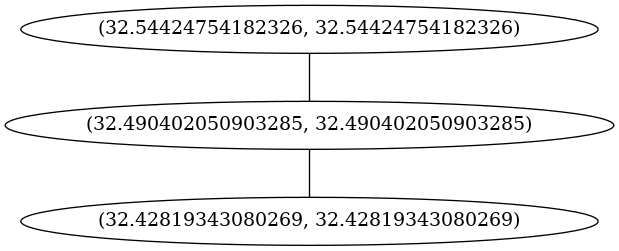

Step #1
Curr Path: head --> (32.54424754182326, 32.54424754182326) <--> (32.490402050903285, 32.490402050903285) <-- tail


Step #2
Curr Path: head --> (32.54424754182326, 32.54424754182326) <--> (32.490402050903285, 32.490402050903285) <--> (32.42819343080269, 32.42819343080269) <-- tail


Step #3
Curr Path: head -->  <-- tail


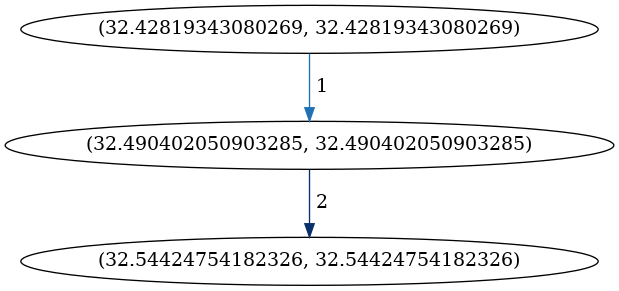

-------------------------------
Connected component: {'(32.62360335860146, 32.62360335860146)', '(32.55379538603918, 32.55379538603918)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(32.74162456332777, 32.74162456332777)', '(32.730002799746266, 32.730002799746266)', '(32.667855884274054, 32.667855884274054)'}
Original graph


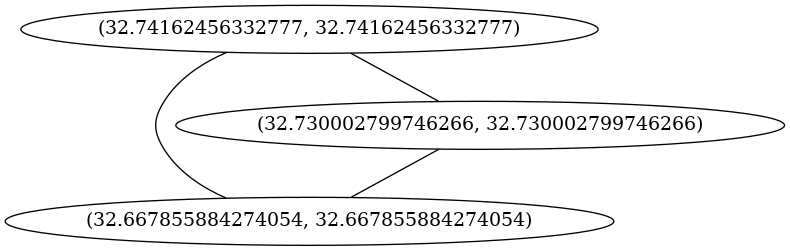

Step #1
Curr Path: head --> (32.74162456332777, 32.74162456332777) <--> (32.667855884274054, 32.667855884274054) <-- tail


Step #2
Curr Path: head --> (32.74162456332777, 32.74162456332777) <--> (32.667855884274054, 32.667855884274054) <--> (32.730002799746266, 32.730002799746266) <-- tail


Step #3
Curr Path: head --> (32.74162456332777, 32.74162456332777) <--> (32.667855884274054, 32.667855884274054) <--> (32.730002799746266, 32.730002799746266) <--> (32.74162456332777, 32.74162456332777) <-- tail


Step #4
Curr Path: head -->  <-- tail


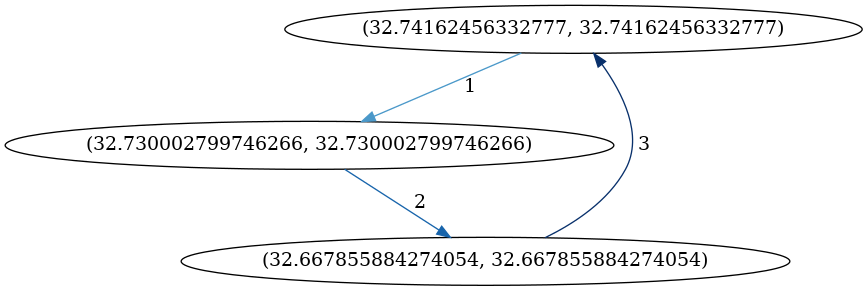

-------------------------------
Connected component: {'(32.83898368924655, 32.83898368924655)', '(32.812148409573304, 32.812148409573304)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(33.12611145699206, 33.12611145699206)', '(33.13104640361046, 33.13104640361046)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(33.12675005062142, 33.12675005062142)', '(33.16122525516479, 33.16122525516479)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(33.4090346210211, 33.4090346210211)', '(33.399379720530945, 33.399379720530945)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(33.53445249007793, 33.53445249007793)', '(33.53635512160151, 33.53635512160151)'}
Connected component has just 2 nodes, Eulerian trail

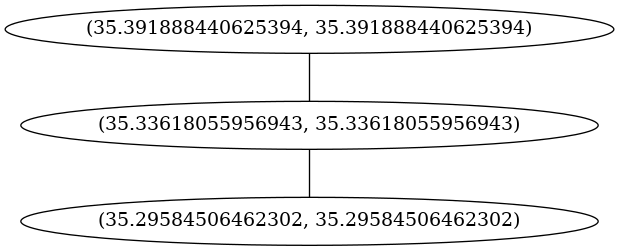

Step #1
Curr Path: head --> (35.391888440625394, 35.391888440625394) <--> (35.33618055956943, 35.33618055956943) <-- tail


Step #2
Curr Path: head --> (35.391888440625394, 35.391888440625394) <--> (35.33618055956943, 35.33618055956943) <--> (35.29584506462302, 35.29584506462302) <-- tail


Step #3
Curr Path: head -->  <-- tail


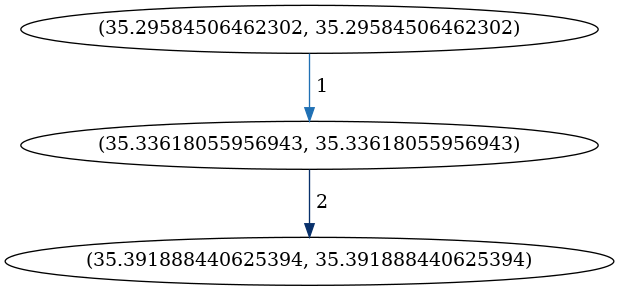

-------------------------------
Connected component: {'(35.344228718816495, 35.344228718816495)', '(35.3367659997433, 35.3367659997433)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(35.40042411616274, 35.40042411616274)', '(35.44825311071325, 35.44825311071325)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(35.44803199299912, 35.44803199299912)', '(35.4805823335263, 35.4805823335263)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(35.59006115533724, 35.59006115533724)', '(35.60410478965573, 35.60410478965573)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(35.6298782970006, 35.6298782970006)', '(35.615392064027716, 35.615392064027716)'}
Connected component has just 2 nodes, Eulerian trail is 

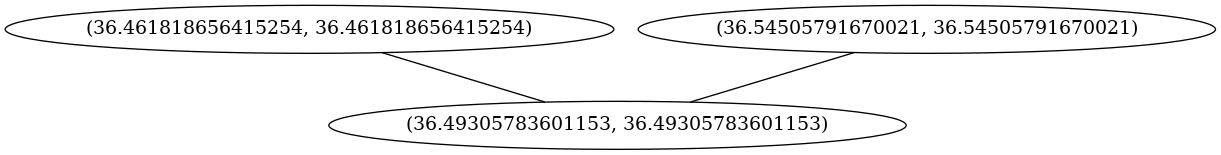

Step #1
Curr Path: head --> (36.461818656415254, 36.461818656415254) <--> (36.49305783601153, 36.49305783601153) <-- tail


Step #2
Curr Path: head --> (36.461818656415254, 36.461818656415254) <--> (36.49305783601153, 36.49305783601153) <--> (36.54505791670021, 36.54505791670021) <-- tail


Step #3
Curr Path: head -->  <-- tail


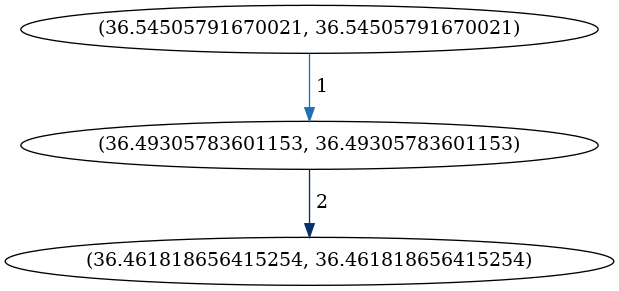

-------------------------------
Connected component: {'(36.49091635672396, 36.49091635672396)', '(36.56036972195428, 36.56036972195428)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(36.765567631059106, 36.765567631059106)', '(36.75657156526611, 36.75657156526611)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(36.833198466424406, 36.833198466424406)', '(36.8536213899148, 36.8536213899148)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(36.86977975335485, 36.86977975335485)', '(36.88007726497611, 36.88007726497611)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(36.97619468309686, 36.97619468309686)', '(36.90755741507972, 36.90755741507972)'}
Connected component has just 2 nodes, Eulerian trail

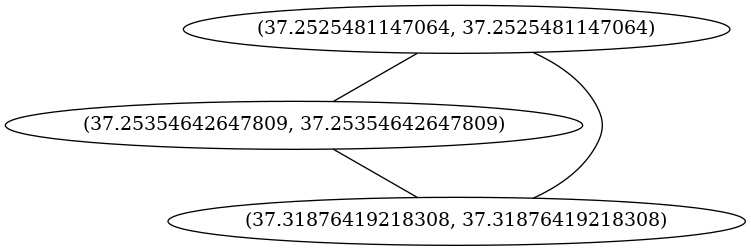

Step #1
Curr Path: head --> (37.2525481147064, 37.2525481147064) <--> (37.25354642647809, 37.25354642647809) <-- tail


Step #2
Curr Path: head --> (37.2525481147064, 37.2525481147064) <--> (37.25354642647809, 37.25354642647809) <--> (37.31876419218308, 37.31876419218308) <-- tail


Step #3
Curr Path: head --> (37.2525481147064, 37.2525481147064) <--> (37.25354642647809, 37.25354642647809) <--> (37.31876419218308, 37.31876419218308) <--> (37.2525481147064, 37.2525481147064) <-- tail


Step #4
Curr Path: head -->  <-- tail


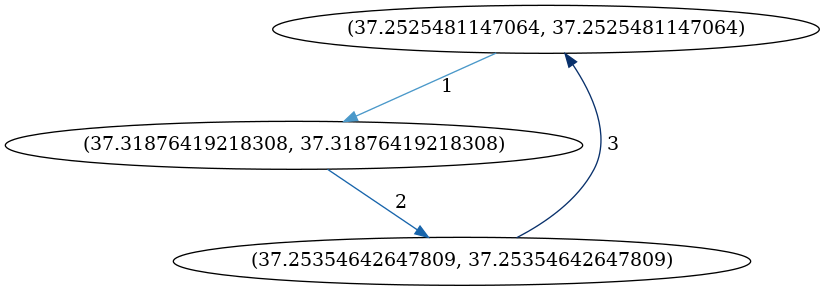

-------------------------------
Connected component: {'(37.29098881052466, 37.29098881052466)', '(37.3316534339572, 37.3316534339572)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(37.47745000461053, 37.47745000461053)', '(37.443944850708164, 37.443944850708164)', '(37.365561969525444, 37.365561969525444)'}
Original graph


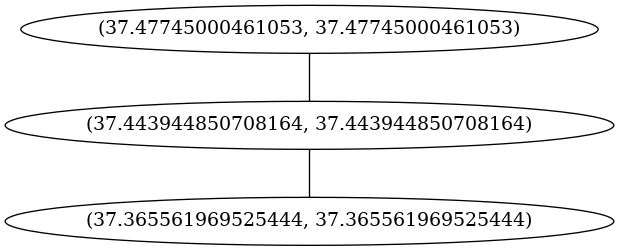

Step #1
Curr Path: head --> (37.47745000461053, 37.47745000461053) <--> (37.443944850708164, 37.443944850708164) <-- tail


Step #2
Curr Path: head --> (37.47745000461053, 37.47745000461053) <--> (37.443944850708164, 37.443944850708164) <--> (37.365561969525444, 37.365561969525444) <-- tail


Step #3
Curr Path: head -->  <-- tail


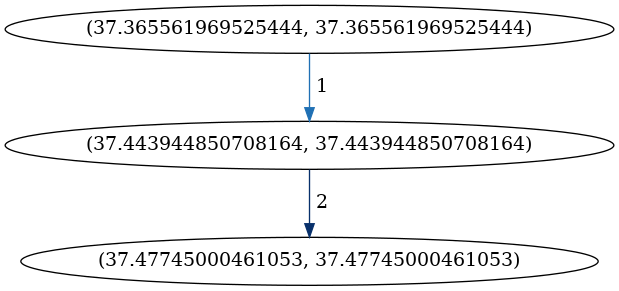

-------------------------------
Connected component: {'(37.868997108141805, 37.868997108141805)', '(37.83329551194229, 37.83329551194229)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.1033684718567, 38.1033684718567)', '(38.15649490295313, 38.15649490295313)', '(38.10740660676044, 38.10740660676044)'}
Original graph


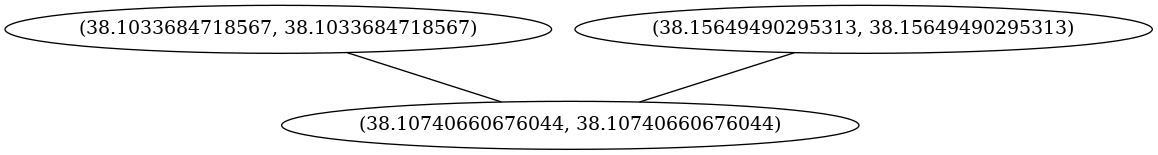

Step #1
Curr Path: head --> (38.1033684718567, 38.1033684718567) <--> (38.10740660676044, 38.10740660676044) <-- tail


Step #2
Curr Path: head --> (38.1033684718567, 38.1033684718567) <--> (38.10740660676044, 38.10740660676044) <--> (38.15649490295313, 38.15649490295313) <-- tail


Step #3
Curr Path: head -->  <-- tail


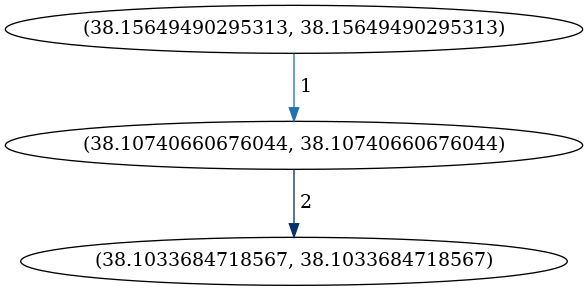

-------------------------------
Connected component: {'(38.211422763524226, 38.211422763524226)', '(38.142706508455085, 38.142706508455085)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.25090553299638, 38.25090553299638)', '(38.29532987637535, 38.29532987637535)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.2329887932273, 38.2329887932273)', '(38.308965925039104, 38.308965925039104)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.35059172056717, 38.35059172056717)', '(38.38120479634288, 38.38120479634288)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(38.332671176446205, 38.332671176446205)', '(38.39887143955712, 38.39887143955712)'}
Connected component has just 2 nodes, Eulerian t

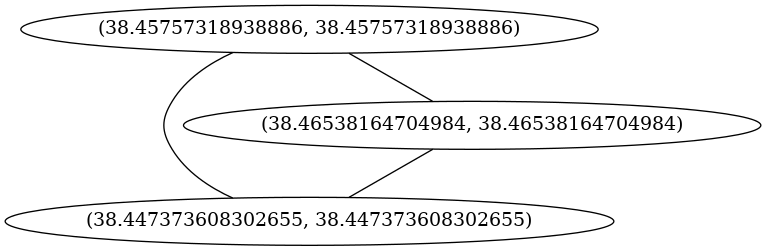

Step #1
Curr Path: head --> (38.45757318938886, 38.45757318938886) <--> (38.447373608302655, 38.447373608302655) <-- tail


Step #2
Curr Path: head --> (38.45757318938886, 38.45757318938886) <--> (38.447373608302655, 38.447373608302655) <--> (38.46538164704984, 38.46538164704984) <-- tail


Step #3
Curr Path: head --> (38.45757318938886, 38.45757318938886) <--> (38.447373608302655, 38.447373608302655) <--> (38.46538164704984, 38.46538164704984) <--> (38.45757318938886, 38.45757318938886) <-- tail


Step #4
Curr Path: head -->  <-- tail


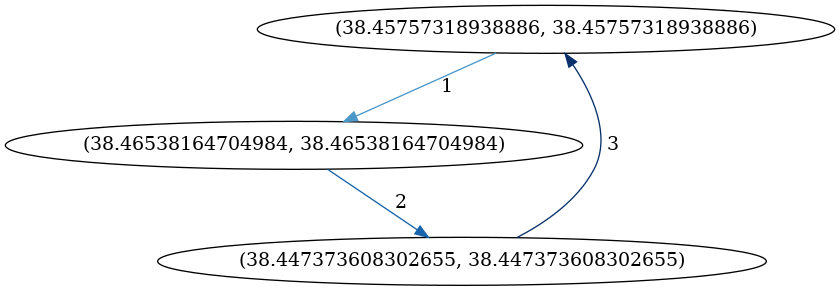

-------------------------------
Connected component: {'(38.74148015944414, 38.74148015944414)', '(38.713232775676246, 38.713232775676246)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(39.082557780124816, 39.082557780124816)', '(39.081945361328785, 39.081945361328785)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(39.21433639428483, 39.21433639428483)', '(39.15765562744217, 39.15765562744217)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(39.27317930857783, 39.27317930857783)', '(39.256923435971416, 39.256923435971416)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(39.358446088715795, 39.358446088715795)', '(39.414541146817115, 39.414541146817115)'}
Connected component has just 2 nodes, Eule

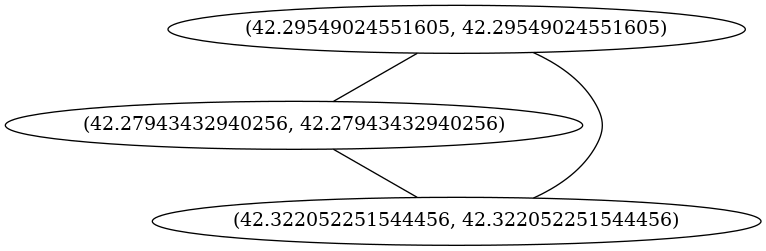

Step #1
Curr Path: head --> (42.29549024551605, 42.29549024551605) <--> (42.27943432940256, 42.27943432940256) <-- tail


Step #2
Curr Path: head --> (42.29549024551605, 42.29549024551605) <--> (42.27943432940256, 42.27943432940256) <--> (42.322052251544456, 42.322052251544456) <-- tail


Step #3
Curr Path: head --> (42.29549024551605, 42.29549024551605) <--> (42.27943432940256, 42.27943432940256) <--> (42.322052251544456, 42.322052251544456) <--> (42.29549024551605, 42.29549024551605) <-- tail


Step #4
Curr Path: head -->  <-- tail


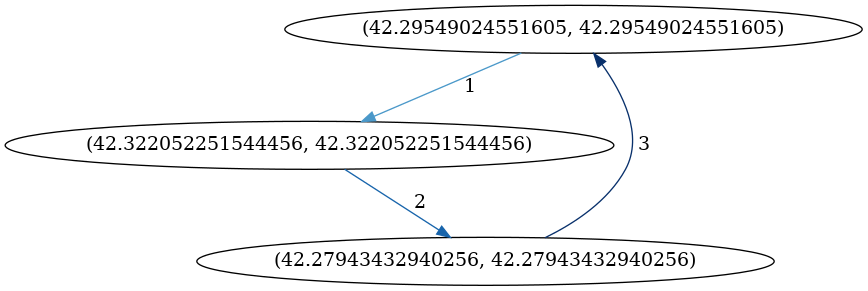

-------------------------------
Connected component: {'(42.361692152835886, 42.361692152835886)', '(42.323819220164225, 42.323819220164225)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(42.56305085329829, 42.56305085329829)', '(42.58727531296207, 42.58727531296207)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(42.85512655573666, 42.85512655573666)', '(42.862045087959245, 42.862045087959245)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(43.00503951846617, 43.00503951846617)', '(42.982054452496016, 42.982054452496016)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(43.10423272643871, 43.10423272643871)', '(43.0865010030059, 43.0865010030059)'}
Connected component has just 2 nodes, Eulerian t

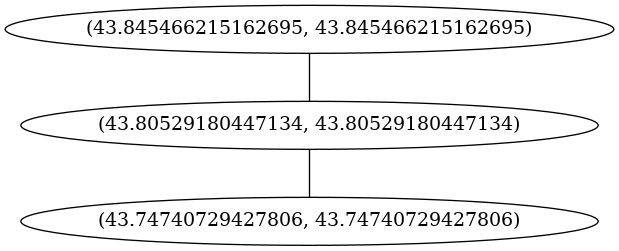

Step #1
Curr Path: head --> (43.845466215162695, 43.845466215162695) <--> (43.80529180447134, 43.80529180447134) <-- tail


Step #2
Curr Path: head --> (43.845466215162695, 43.845466215162695) <--> (43.80529180447134, 43.80529180447134) <--> (43.74740729427806, 43.74740729427806) <-- tail


Step #3
Curr Path: head -->  <-- tail


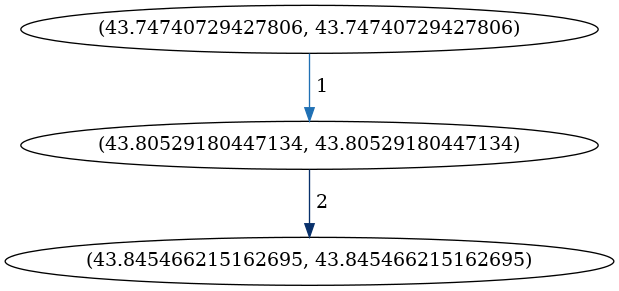

-------------------------------
Connected component: {'(43.81117244549021, 43.81117244549021)', '(43.78412549488373, 43.78412549488373)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(43.82347833146514, 43.82347833146514)', '(43.757434790830565, 43.757434790830565)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(43.940741893266164, 43.940741893266164)', '(43.97564841691283, 43.97564841691283)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(44.04673681896151, 44.04673681896151)', '(43.995347735144364, 43.995347735144364)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(44.26784616193072, 44.26784616193072)', '(44.33791929204463, 44.33791929204463)'}
Connected component has just 2 nodes, Eulerian t

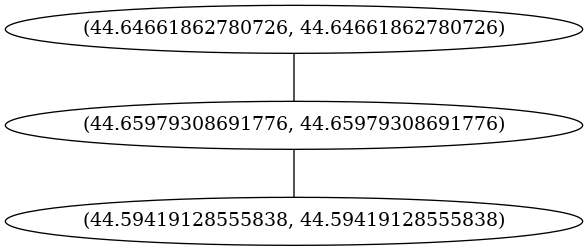

Step #1
Curr Path: head --> (44.64661862780726, 44.64661862780726) <--> (44.65979308691776, 44.65979308691776) <-- tail


Step #2
Curr Path: head --> (44.64661862780726, 44.64661862780726) <--> (44.65979308691776, 44.65979308691776) <--> (44.59419128555838, 44.59419128555838) <-- tail


Step #3
Curr Path: head -->  <-- tail


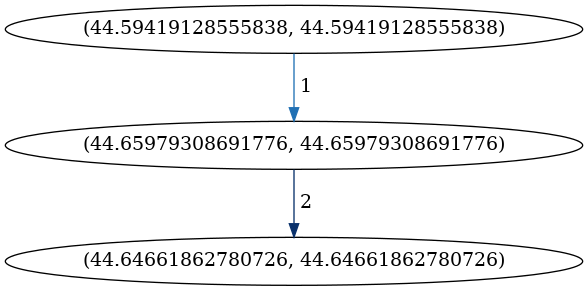

-------------------------------
Connected component: {'(44.677040255434214, 44.677040255434214)', '(44.66833124711898, 44.66833124711898)', '(44.61333836039748, 44.61333836039748)'}
Original graph


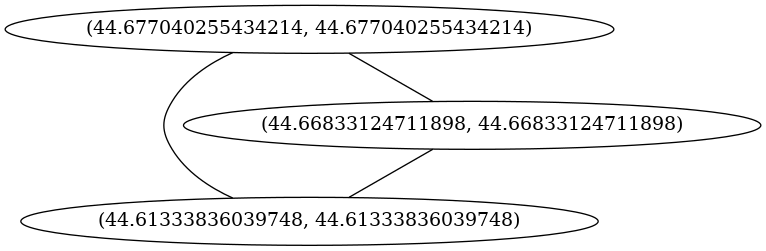

Step #1
Curr Path: head --> (44.677040255434214, 44.677040255434214) <--> (44.61333836039748, 44.61333836039748) <-- tail


Step #2
Curr Path: head --> (44.677040255434214, 44.677040255434214) <--> (44.61333836039748, 44.61333836039748) <--> (44.66833124711898, 44.66833124711898) <-- tail


Step #3
Curr Path: head --> (44.677040255434214, 44.677040255434214) <--> (44.61333836039748, 44.61333836039748) <--> (44.66833124711898, 44.66833124711898) <--> (44.677040255434214, 44.677040255434214) <-- tail


Step #4
Curr Path: head -->  <-- tail


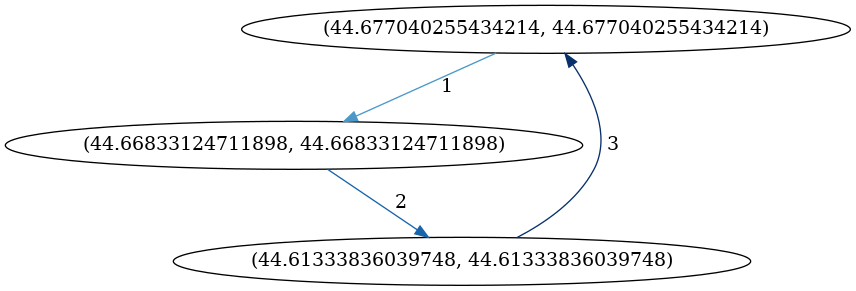

-------------------------------
Connected component: {'(44.97288934365913, 44.97288934365913)', '(44.97213340646316, 44.97213340646316)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.080503824176944, 45.080503824176944)', '(45.01785711722693, 45.01785711722693)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.09429798922837, 45.09429798922837)', '(45.024560487527246, 45.024560487527246)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.088174897894255, 45.088174897894255)', '(45.127367817625995, 45.127367817625995)', '(45.15410072357035, 45.15410072357035)', '(45.123079722888306, 45.123079722888306)'}
Original graph


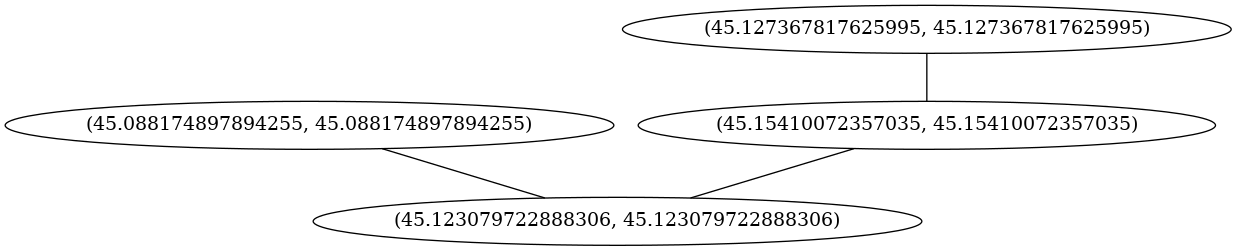

Step #1
Curr Path: head --> (45.088174897894255, 45.088174897894255) <--> (45.123079722888306, 45.123079722888306) <-- tail


Step #2
Curr Path: head --> (45.088174897894255, 45.088174897894255) <--> (45.123079722888306, 45.123079722888306) <--> (45.15410072357035, 45.15410072357035) <-- tail


Step #3
Curr Path: head --> (45.088174897894255, 45.088174897894255) <--> (45.123079722888306, 45.123079722888306) <--> (45.15410072357035, 45.15410072357035) <--> (45.127367817625995, 45.127367817625995) <-- tail


Step #4
Curr Path: head -->  <-- tail


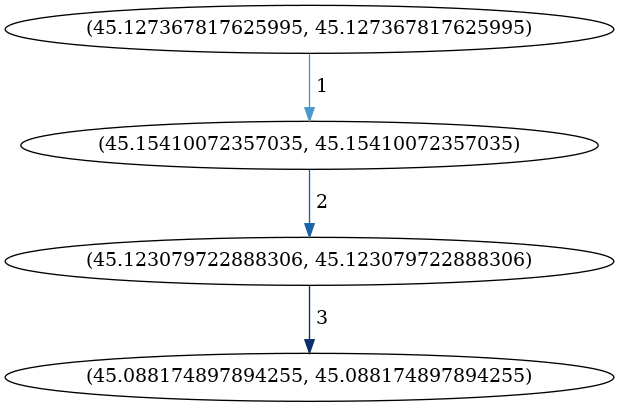

-------------------------------
Connected component: {'(45.119041289229585, 45.119041289229585)', '(45.17799419635142, 45.17799419635142)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.26602822585145, 45.26602822585145)', '(45.22443251825489, 45.22443251825489)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.42938111950895, 45.42938111950895)', '(45.383167680296076, 45.383167680296076)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.575820027412384, 45.575820027412384)', '(45.50301459259976, 45.50301459259976)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(45.89814584386543, 45.89814584386543)', '(45.94159565977925, 45.94159565977925)'}
Connected component has just 2 nodes, Eulerian t

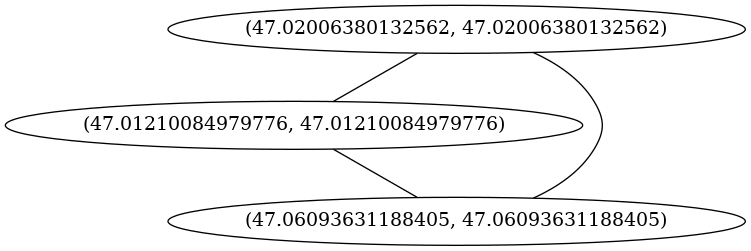

Step #1
Curr Path: head --> (47.02006380132562, 47.02006380132562) <--> (47.01210084979776, 47.01210084979776) <-- tail


Step #2
Curr Path: head --> (47.02006380132562, 47.02006380132562) <--> (47.01210084979776, 47.01210084979776) <--> (47.06093631188405, 47.06093631188405) <-- tail


Step #3
Curr Path: head --> (47.02006380132562, 47.02006380132562) <--> (47.01210084979776, 47.01210084979776) <--> (47.06093631188405, 47.06093631188405) <--> (47.02006380132562, 47.02006380132562) <-- tail


Step #4
Curr Path: head -->  <-- tail


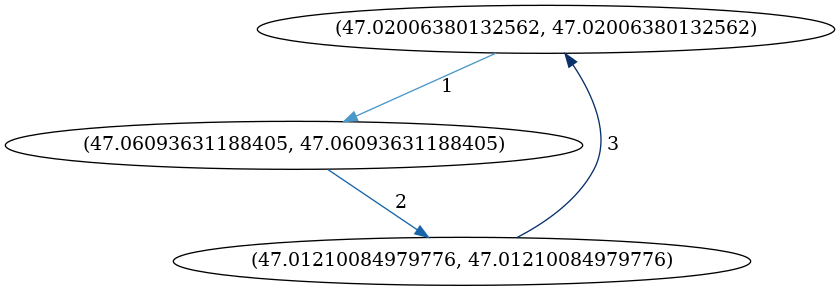

-------------------------------
Connected component: {'(47.06959705434048, 47.06959705434048)', '(47.04843626891003, 47.04843626891003)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(47.218865354677945, 47.218865354677945)', '(47.17968855801409, 47.17968855801409)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(47.25860525355858, 47.25860525355858)', '(47.26754862781722, 47.26754862781722)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(47.29384130116835, 47.29384130116835)', '(47.349602673958685, 47.349602673958685)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(47.39822428047691, 47.39822428047691)', '(47.33938819241884, 47.33938819241884)'}
Connected component has just 2 nodes, Eulerian tra

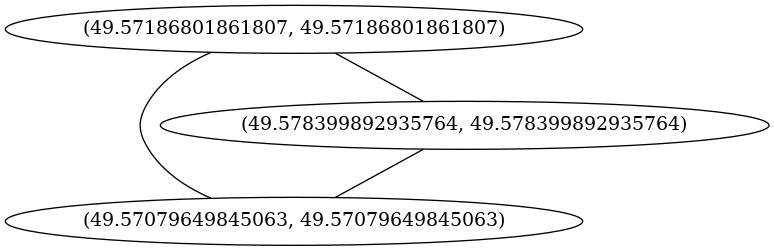

Step #1
Curr Path: head --> (49.57186801861807, 49.57186801861807) <--> (49.57079649845063, 49.57079649845063) <-- tail


Step #2
Curr Path: head --> (49.57186801861807, 49.57186801861807) <--> (49.57079649845063, 49.57079649845063) <--> (49.578399892935764, 49.578399892935764) <-- tail


Step #3
Curr Path: head --> (49.57186801861807, 49.57186801861807) <--> (49.57079649845063, 49.57079649845063) <--> (49.578399892935764, 49.578399892935764) <--> (49.57186801861807, 49.57186801861807) <-- tail


Step #4
Curr Path: head -->  <-- tail


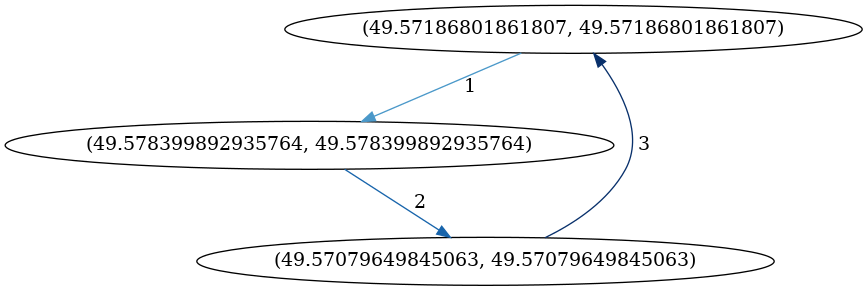

-------------------------------
Connected component: {'(49.633397199009764, 49.633397199009764)', '(49.71473189541066, 49.71473189541066)', '(49.655650096311675, 49.655650096311675)'}
Original graph


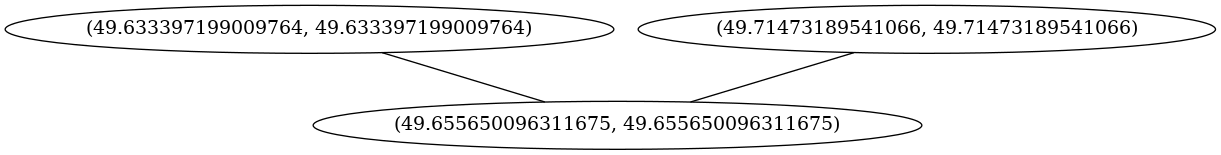

Step #1
Curr Path: head --> (49.633397199009764, 49.633397199009764) <--> (49.655650096311675, 49.655650096311675) <-- tail


Step #2
Curr Path: head --> (49.633397199009764, 49.633397199009764) <--> (49.655650096311675, 49.655650096311675) <--> (49.71473189541066, 49.71473189541066) <-- tail


Step #3
Curr Path: head -->  <-- tail


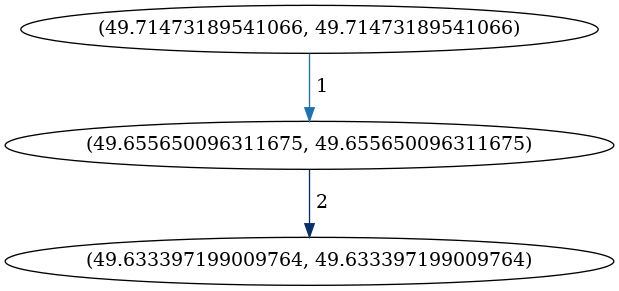

-------------------------------
Connected component: {'(49.7634696948062, 49.7634696948062)', '(49.797674083525834, 49.797674083525834)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(49.81009597611238, 49.81009597611238)', '(49.844104512527416, 49.844104512527416)', '(49.793480424513874, 49.793480424513874)'}
Original graph


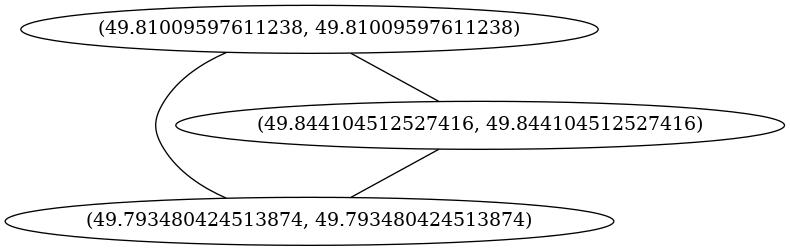

Step #1
Curr Path: head --> (49.81009597611238, 49.81009597611238) <--> (49.793480424513874, 49.793480424513874) <-- tail


Step #2
Curr Path: head --> (49.81009597611238, 49.81009597611238) <--> (49.793480424513874, 49.793480424513874) <--> (49.844104512527416, 49.844104512527416) <-- tail


Step #3
Curr Path: head --> (49.81009597611238, 49.81009597611238) <--> (49.793480424513874, 49.793480424513874) <--> (49.844104512527416, 49.844104512527416) <--> (49.81009597611238, 49.81009597611238) <-- tail


Step #4
Curr Path: head -->  <-- tail


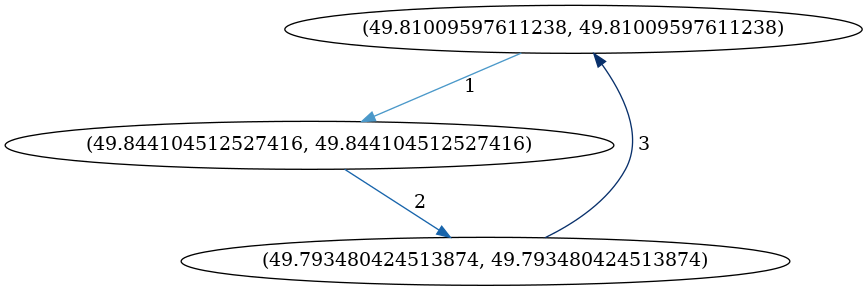

-------------------------------
Connected component: {'(49.82175679599748, 49.82175679599748)', '(49.79340557785643, 49.79340557785643)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(49.836726326952224, 49.836726326952224)', '(49.774997692483424, 49.774997692483424)'}
Connected component has just 2 nodes, Eulerian trail is trivial
-------------------------------
Connected component: {'(49.88336296278086, 49.88336296278086)', '(49.818839507846675, 49.818839507846675)', '(49.8648548852878, 49.8648548852878)'}
Original graph


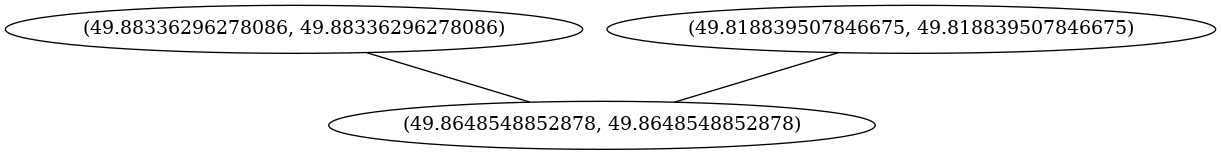

Step #1
Curr Path: head --> (49.88336296278086, 49.88336296278086) <--> (49.8648548852878, 49.8648548852878) <-- tail


Step #2
Curr Path: head --> (49.88336296278086, 49.88336296278086) <--> (49.8648548852878, 49.8648548852878) <--> (49.818839507846675, 49.818839507846675) <-- tail


Step #3
Curr Path: head -->  <-- tail


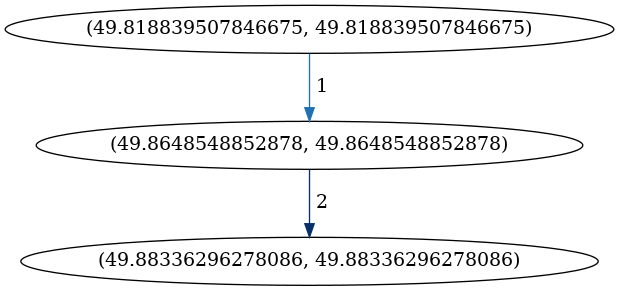

In [375]:
run(R, hierholzer)

#dLong = dataframe.sort_values(by='long')

#datas = pd.DataFrame(d)

# O(n) Cleaning data
# Removing unusable latitude / longitude
#for i in range(len(d)):
#    if d[i]['lat'] != 0 and d[i]['long'] != 0:
#        dLong.append(d[i])

# O(n log n)
#dLong.sort(key=sortLongFun)

#dLat = dLong.copy()

# O(n log n)
#dLat.sort(key=sortLatFun)  



import pixiedust
import pdb

def sortLatFun(elem):
    return elem['lat']

def sortLongFun(elem):
    return elem['long']

def my_print(d):
    for i in range(len(d)):
        display(d[i]['lat'])
        
'''
def binarySearch(list, item_index):
    first = 0
    last = len(list)-1

    while first <= last:
        midpoint = (first + last)//2
        if item_index
           list[item_index]['lat'] - radius <= list[midpoint]['lat'] and \
           list[item_index]['lat'] + radius >= list[midpoint]['lat'] and \
           list[item_index]['long'] - radius <= list[midpoint]['long'] and \
           list[item_index]['long'] + radius >= list[midpoint]['long']:
            
            
        else:
            if item < list[midpoint]:
                last = midpoint-1
            else:
                first = midpoint+1

    return found
'''
'''
def binarySearch(d, item, item_index):
    if len(d) == 0:
        return
    
    midpoint = len(d) // 2
    HEAD = "len:" + str(len(d)) + ", midpoint: " + str(midpoint) + ", item_lat: " + str(item['lat']) + ", midpoint_lat: " + str(d[midpoint]['lat'])
    my_print(d)

    if item['lat'] - radius <= d[midpoint]['lat'] and \
       item['lat'] + radius >= d[midpoint]['lat']:
        if len(d) >= midpoint and midpoint != 0:
            display(HEAD + " - Calling: d[:" + str(midpoint) + "] ")
            binarySearch(d[:midpoint], item, item_index)
        
        if len(d) > midpoint+1:
            display(HEAD + " - Calling: d[" + str(midpoint+1) + ":] ")
            binarySearch(d[midpoint+1:], item, item_index)
            
        if item['long'] - radius <= d[midpoint]['long'] and \
           item['long'] + radius >= d[midpoint]['long'] and \
           item != d[midpoint]:
            display(HEAD + " - Adding edge")
            P.add_edge(midpoint, item_index)
    else:
        if item['lat'] < d[midpoint]['lat'] and \
           len(d) >= midpoint and \
           midpoint != 0:
            display(HEAD + " - Else Calling: d[:" + str(midpoint) + "] ")
            binarySearch(d[:midpoint], item, item_index)
        elif len(d) > midpoint + 1:
                display(HEAD + " - Else Calling: d[" + str(midpoint+1) + ":] ")
                binarySearch(d[midpoint+1:], item, item_index)
'''
'''
def binarySearch(d, item):
    midpoint = len(d)//2
    HEAD = "len:" + str(len(d)) + ", midpoint " + str(midpoint) + ", " + str(item['lat']) + ", " + str(d[midpoint]['lat'])
    display(HEAD)
    if item['lat'] - radius <= d[midpoint]['lat'] and \
       item['lat'] + radius >= d[midpoint]['lat']:
        if len(d) >= midpoint:
            display(HEAD + " - Calling: d[:" + str(midpoint) + "] ")
            binarySearch(d[:midpoint], item)
        
        if len(d) > midpoint+1:
            display(HEAD + " - Calling: d[" + str(midpoint+1) + ":] ")
            binarySearch(d[midpoint+1:], item)
            
        if item['long'] - radius <= d[midpoint]['long'] and \
           item['long'] + radius >= d[midpoint]['long'] and \
           item != midpoint:
            display(HEAD + " - Adding edge")
            P.add_edge(midpoint, item)
    else:
        if item['lat'] < d[midpoint]['lat'] and len(d) >= midpoint:
            display(HEAD + " - Else Calling: d[:" + str(midpoint) + "] ")
            binarySearch(d[:midpoint], item)
        elif len(d) > midpoint + 1:
                display(HEAD + " - Else Calling: d[" + str(midpoint+1) + ":] ")
                binarySearch(d[midpoint+1:], item)
'''                 

import random
display(len(d))
d = random.sample(d, 1500)